
# FC-by-timepoints for Multi layer community detection algorithm

This notebook loads rs-fMRI runs, extracts region-wise timeseries using a label atlas, concatenates each subject’s two runs, applies an overlapping sliding window (default: **30 s** window, **1 TR** step), and computes a **Pearson correlation** Functional Connectivity (FC) matrix per window.  
It organizes the outputs as tensors with shape **(subjects × windows × regions × regions)** per group, and prints final tensor sizes for each group.

**defaults params**
- Total scan per subject: 14 minutes (two runs of ~7 minutes each)
- TR = 2 s → ~420 TRs per concatenated run
- TR drop per run: e.g., dropping TR to ensure consistency → 205 + 205 = 410 TRs.
- Window length = 30 s → 15 TRs
- $N_{win} = T − W + 1$; 
- Step size = 1 TR; number of windows $N_{win} = 410 − 15 + 1 = 396$
- If step size = (50% of 15 TRs = 7.5 TR) 8 TR; number of windows $N_{win} = \left\lfloor \frac{395}{8} \right\rfloor + 1 = 49+1 = 50$ windows






## 1. Imports & Configuration

In [1]:
import os, glob, logging
from dataclasses import dataclass
from typing import Dict, List, Tuple
from datetime import datetime

from nilearn import datasets
from teneto import communitymeasures

import matplotlib.patches as patches
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from nilearn import datasets, plotting
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from scipy.io import savemat
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from matplotlib import patches 
from itertools import combinations, product, permutations
from pathlib import Path
from math import factorial

In [2]:
# ---- OOP Environment var ----
@dataclass
class Config:
    data_path: str
    groups: List[str]                 # e.g., ['cFES_Pre','cycling_Pre','cFES_Post','cycling_Post']
    tr: float = 2.0                   # seconds
    window_length_sec: float = 30.0   # seconds
    step_size_tr: int = 1             # in TRs
    fmri_prefix: str = "errts"        # file prefix
    expect_regions: int = 200         # atlas parcels
    runs_per_subject: int = 2
    verbose: bool = True

cfg = Config(
    data_path="/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data",
    # groups=["cFES_Pre", "cycling_Pre", "cFES_Post", "cycling_Post"],
    groups=["pre_fes", "pre_nfes", "post_fes", "post_nfes"],
    tr=2.0,
    window_length_sec=30.0,
    step_size_tr=1, # 1 7 8
    fmri_prefix="errts",
    expect_regions=200,
    runs_per_subject=2,
    verbose=True,
)

print(f"   Data path: {cfg.data_path}")
print(f"   Groups: {cfg.groups}")
print(f"   TR: {cfg.tr}s | Window: {cfg.window_length_sec}s | Step: {cfg.step_size_tr} TR")

   Data path: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data
   Groups: ['pre_fes', 'pre_nfes', 'post_fes', 'post_nfes']
   TR: 2.0s | Window: 30.0s | Step: 1 TR


## 2. Atlas Fetch & Quick Visual Check

[fetch_atlas_schaefer_2018] Dataset found in /Users/ismaila/nilearn_data/schaefer_2018
Atlas ROIs are located in nifti image at: /Users/ismaila/nilearn_data/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_1mm.nii.gz


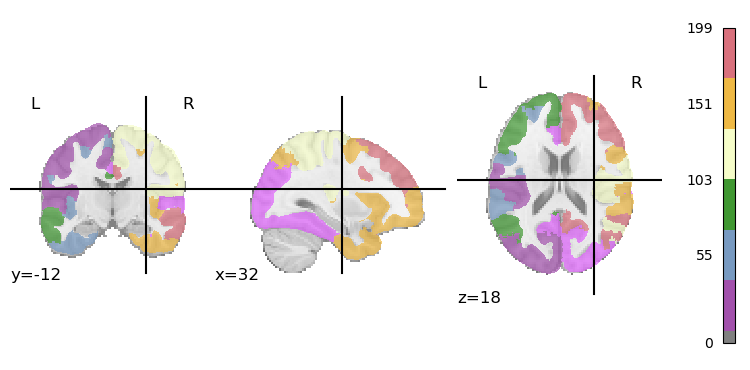

In [3]:
# Atlas Setup & Quick Visualization (Schaefer-2018, 200 parcels, Yeo-7)

start_time = datetime.now()

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=cfg.expect_regions, yeo_networks=7, resolution_mm=1)
atlas_filename = atlas.maps
labels = np.asarray(atlas.labels).astype('U')

# Yeo-7 inspired palette (7 colors)
my_colors = ['#A251AC', '#789AC1', '#409832', '#E165FE', '#F6FDC9', '#EFB944', '#D9717D']
cmap = ListedColormap(my_colors)

# Plot the atlas (display only, do not save)
disp = plotting.plot_roi(atlas_filename, cmap=cmap)
print(f'Atlas ROIs are located in nifti image at: {atlas_filename}')


## 3. Build Masker (Atlas-Based Time Series Extraction)

In [4]:
masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds=True,
    memory="nilearn_cache",
    verbose=0,
    t_r=cfg.tr,
)

# connectome = ConnectivityMeasure(kind="correlation")
connectome = ConnectivityMeasure(kind="correlation", standardize="zscore_sample")

print(" Masker & ConnectivityMeasure Done ✅")
print(f"   Masker TR: {cfg.tr}s | Standardize: zscore_sample")
print(f"   FC kind: Pearson correlation")


 Masker & ConnectivityMeasure Done ✅
   Masker TR: 2.0s | Standardize: zscore_sample
   FC kind: Pearson correlation


In [5]:
def build_masker(atlas_filename: str, tr: float) -> NiftiLabelsMasker:
    # Prefer sample z-scoring if your nilearn supports it
    try:
        masker = NiftiLabelsMasker(
            labels_img=atlas_filename,
            standardize='zscore_sample',     # ok if available
            standardize_confounds=True,      # <-- must be bool
            memory='nilearn_cache',
            verbose=0,
            t_r=tr,
        )
    except TypeError:
        # Older nilearn: fallback to boolean standardize
        masker = NiftiLabelsMasker(
            labels_img=atlas_filename,
            standardize=True,
            standardize_confounds=True,      # <-- keep bool
            memory='nilearn_cache',
            verbose=0,
            t_r=tr,
        )
    return masker

if not hasattr(cfg, "atlas_filename"):
    cfg.atlas_filename = atlas.maps  # or the full path to your atlas .nii/.nii.gz
# masker = build_masker(cfg.atlas_filename, cfg.tr)

# Rebuild the masker before running test
masker = build_masker(atlas_filename, cfg.tr)

## 4. Utils: Raw NIfTI Files (Per Group) & Verify Pairing

In [6]:
def list_group_niis(group_dir: str, prefix: str) -> List[str]:
    patt1 = os.path.join(group_dir, f"{prefix}*.nii")
    patt2 = os.path.join(group_dir, f"{prefix}*.nii.gz")
    files = sorted(glob.glob(patt1) + glob.glob(patt2))
    return files

def pair_runs_consecutively(run_paths: List[str], runs_per_subject: int = 2) -> List[Tuple[str, ...]]:
    if len(run_paths) % runs_per_subject != 0:
        raise ValueError(
            f"Found {len(run_paths)} runs, not divisible by runs_per_subject={runs_per_subject}."
        )
    pairs = []
    for i in range(0, len(run_paths), runs_per_subject):
        pairs.append(tuple(run_paths[i : i + runs_per_subject]))
    return pairs

group_runs: Dict[str, List[str]] = {}
group_pairs: Dict[str, List[Tuple[str, ...]]] = {}

print("Scanning groups for raw NIfTI runs...")
for grp in cfg.groups:
    grp_dir = os.path.join(cfg.data_path, grp)
    if not os.path.isdir(grp_dir):
        raise FileNotFoundError(f"Group directory not found: {grp_dir}")

    runs = list_group_niis(grp_dir, cfg.fmri_prefix)
    group_runs[grp] = runs
    pairs = pair_runs_consecutively(runs, cfg.runs_per_subject)
    group_pairs[grp] = pairs

    # Summary
    print(f"   [{grp}] runs: {len(runs)} | subjects (by pairing): {len(pairs)}")
    if len(runs) > 0:
        print(f"     first 4 runs: {runs[:4]}")
    if len(pairs) > 0:
        print(f"     first pairing: {pairs[0]}")


Scanning groups for raw NIfTI runs...
   [pre_fes] runs: 14 | subjects (by pairing): 7
     first 4 runs: ['/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes03a.r01.fanaticor+tlrc.nii.gz', '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes03a.r02.fanaticor+tlrc.nii.gz', '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes07a.r01.fanaticor+tlrc.nii.gz', '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes07a.r02.fanaticor+tlrc.nii.gz']
     first pairing: ('/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes03a.r01.fanaticor+tlrc.nii.gz', '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes03a.r02.fanaticor+tlrc.nii.gz')
   [pre_nfes] runs: 10 | subjects (by pairing): 5
     first 4 runs: ['/Users/ismaila/Documents/C-Codes/SCI_FES_Grap

## 5. Helpers: Extract TS, Concatenate, Windowing, FC

In [23]:
def extract_run_timeseries(nii_path: str) -> np.ndarray:
    ts = masker.fit_transform(nii_path)  # (T, R)
    if ts.ndim != 2:
        raise ValueError(f"Timeseries not 2D for {nii_path}: {ts.shape}")
    if ts.shape[1] != cfg.expect_regions:
        raise ValueError(f"Expected {cfg.expect_regions} regions, got {ts.shape[1]} in {nii_path}")
    return ts

def concat_subject_runs(run_ts_list: List[np.ndarray]) -> np.ndarray:
    region_counts = {ts.shape[1] for ts in run_ts_list}
    if len(region_counts) != 1:
        raise ValueError(f"Region mismatch across runs: {region_counts}")
    return np.concatenate(run_ts_list, axis=0)

def sliding_window_indices(n_timepoints: int, window_trs: int, step_trs: int) -> List[Tuple[int, int]]:
    idx = []
    s = 0
    while s + window_trs <= n_timepoints:
        idx.append((s, s + window_trs))
        s += step_trs
    return idx

def timeseries_to_window_list(ts: np.ndarray, window_trs: int, step_trs: int) -> List[np.ndarray]:
    idx = sliding_window_indices(ts.shape[0], window_trs, step_trs)
    return [ts[s:e, :] for (s, e) in idx]


# Function 1: WITHOUT Fisher Z-Transform (original)
def compute_fc_per_window(windows: List[np.ndarray]) -> np.ndarray:
    if len(windows) == 0:
        return np.zeros((0, 0, 0), dtype=np.float32)
    fc_list = connectome.fit_transform(windows)  # (n_windows, R, R)
    return np.asarray(fc_list, dtype=np.float32)
    
# # WITH Fisher Z-Transform
# def compute_fc_per_window(windows: List[np.ndarray]) -> np.ndarray:
#     """
#     Compute functional connectivity per window with Fisher Z-Transform.
#     Handles diagonal (r=1) and near-perfect correlations to avoid infinities.
#     """
#     if len(windows) == 0:
#         return np.zeros((0, 0, 0), dtype=np.float32)
    
#     # Compute Pearson correlations
#     fc_list = connectome.fit_transform(windows)  # (n_windows, R, R) in [-1, 1]
    
#     # Clip to avoid infinity at exactly ±1
#     # Common threshold: 0.9999 or 1 - 1e-6
#     fc_clipped = np.clip(fc_list, -0.9999, 0.9999)
    
#     # Apply Fisher z-transform: r -> z
#     fc_z_list = np.arctanh(fc_clipped)
    
#     # Trying to Set diagonal to 0 (since self-correlation is meaningless in z-space) 
#     for i in range(fc_z_list.shape[0]):
#         np.fill_diagonal(fc_z_list[i], 0)
    
#     return np.asarray(fc_z_list, dtype=np.float32)


def compute_fc_per_window(windows: List[np.ndarray]) -> np.ndarray:
    """
    Compute functional connectivity per window with Fisher Z-Transform.
    Filters out windows with zero-variance regions.
    """
    if len(windows) == 0:
        return np.zeros((0, 0, 0), dtype=np.float32)
    
    # Filter windows to remove those with zero-variance regions
    valid_windows = []
    for win in windows:
        # Check if any region has zero variance
        if np.all(np.std(win, axis=0) > 1e-10):
            valid_windows.append(win)
        else:
            print(f"[warn] Skipping window with zero-variance region(s)")
    
    if len(valid_windows) == 0:
        print("[error] All windows have zero-variance regions!")
        return np.zeros((0, 0, 0), dtype=np.float32)
    
    # Compute correlations
    fc_list = connectome.fit_transform(valid_windows)
    
    # Clip to avoid infinity at exactly ±1
    fc_safe = np.clip(fc_list, -0.99999, 0.99999)
    
    # Apply Fisher z-transform
    fc_z_list = np.arctanh(fc_safe)
    
    return np.asarray(fc_z_list, dtype=np.float32)
    

## 6. Parameter Translation & Sanity Check

In [24]:
# Parameter Translation & Sanity check

window_trs = int(round(cfg.window_length_sec / cfg.tr))
step_trs = int(cfg.step_size_tr)

if window_trs < 2:
    raise ValueError("window_trs must be >= 2.")
if step_trs < 1:
    raise ValueError("step_trs must be >= 1.")

expected_trs_per_run = int(round(7 * 60 / cfg.tr))  # ~7 minutes per run
print(f"   window_trs: {window_trs} (from {cfg.window_length_sec}s @ TR={cfg.tr}s)")
print(f"   step_trs:   {step_trs}")
print(f"   expected TRs per run (≈7min): {expected_trs_per_run}")


   window_trs: 15 (from 30.0s @ TR=2.0s)
   step_trs:   1
   expected TRs per run (≈7min): 210


## 7. Run on One Subject (Group1 or cFES_Pre)

In [25]:
# One Subject Test (First Group)

test_grp = cfg.groups[0]
if len(group_pairs[test_grp]) == 0:
    raise RuntimeError(f"No subject pairings in group: {test_grp}")

test_pair = group_pairs[test_grp][0]
run_ts_list = []

print(f"run on group '{test_grp}', subject pair:")
for rp in test_pair:
    print(f"   - Extracting TS: {os.path.basename(rp)}")
    ts = extract_run_timeseries(rp)
    run_ts_list.append(ts)
    # Warn if TR count deviates notably from ~210 for 7min@2s
    if abs(ts.shape[0] - expected_trs_per_run) > 10:
        print(f"     [warn] timepoints={ts.shape[0]} (expected ~{expected_trs_per_run})")
    print(f"     TS shape: {ts.shape}")

ts_concat = concat_subject_runs(run_ts_list)
print(f"   Concatenated TS shape: {ts_concat.shape} (expect ~420 x {cfg.expect_regions})")

windows = timeseries_to_window_list(ts_concat, window_trs, step_trs)
print(f"   Windows created: {len(windows)} (expect ~{ts_concat.shape[0] - window_trs + 1} for step=1)")

fc_w = compute_fc_per_window(windows)
print(f"   FC per-window shape: {fc_w.shape}  (windows x {cfg.expect_regions} x {cfg.expect_regions})")

assert fc_w.ndim == 3 and fc_w.shape[1] == cfg.expect_regions and fc_w.shape[2] == cfg.expect_regions
print("Test done ✅")

run on group 'pre_fes', subject pair:
   - Extracting TS: errts.scifes03a.r01.fanaticor+tlrc.nii.gz
     TS shape: (205, 200)
   - Extracting TS: errts.scifes03a.r02.fanaticor+tlrc.nii.gz
     TS shape: (205, 200)
   Concatenated TS shape: (410, 200) (expect ~420 x 200)
   Windows created: 396 (expect ~396 for step=1)
   FC per-window shape: (396, 200, 200)  (windows x 200 x 200)
Test done ✅


## 8. Pipeline: All Groups-to-FC Tensors

In [26]:
# Full Processing: All Groups → FC Tensors (with Checks)

group_fc_results: Dict[str, np.ndarray] = {}
print("Processing all groups...")

for grp in cfg.groups:
    pairs = group_pairs[grp]
    if len(pairs) == 0:
        print(f"   [{grp}] No subjects found; skipping.")
        continue

    subj_fc_list = []
    n_windows_ref = None

    print(f"   [{grp}] subjects={len(pairs)}")
    for si, pair in enumerate(pairs, start=1):
        run_ts_list = []
        for rp in pair:
            ts = extract_run_timeseries(rp)
            # Quick TR sanity check
            if abs(ts.shape[0] - expected_trs_per_run) > 10 and cfg.verbose:
                print(f"     [warn] {os.path.basename(rp)}: timepoints={ts.shape[0]} (expected ~{expected_trs_per_run})")
            run_ts_list.append(ts)

        ts_concat = concat_subject_runs(run_ts_list)
        windows = timeseries_to_window_list(ts_concat, window_trs, step_trs)
        if len(windows) == 0:
            raise ValueError(f"No windows for subject {si} in group {grp} (T={ts_concat.shape[0]}, window_trs={window_trs}).")

        fc_w = compute_fc_per_window(windows)

        if n_windows_ref is None:
            n_windows_ref = fc_w.shape[0]
        elif fc_w.shape[0] != n_windows_ref:
            raise ValueError(f"[{grp}] Inconsistent window counts across subjects: first had {n_windows_ref}, now {fc_w.shape[0]}")

        subj_fc_list.append(fc_w)
        if cfg.verbose:
            print(f"     Subject {si}: TS {ts_concat.shape} | windows={fc_w.shape[0]} | FC shape={fc_w.shape}")

    grp_tensor = np.stack(subj_fc_list, axis=0).astype(np.float32)  # (subjects, windows, R, R)
    group_fc_results[grp] = grp_tensor
    print(f"   [{grp}] FC tensor: {grp_tensor.shape} (subjects x windows x {cfg.expect_regions} x {cfg.expect_regions})")

print("All groups processed Done✅")


Processing all groups...
   [pre_fes] subjects=7
     Subject 1: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)


/opt/anaconda3/envs/fmri/lib/python3.11/site-packages/nilearn/connectome/connectivity_matrices.py:348: RuntimeWarning: divide by zero encountered in divide
  diagonal = np.atleast_2d(1.0 / np.sqrt(np.diag(covariance)))
/opt/anaconda3/envs/fmri/lib/python3.11/site-packages/nilearn/connectome/connectivity_matrices.py:349: RuntimeWarning: invalid value encountered in multiply
  correlation = covariance * diagonal * diagonal.T


     Subject 2: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 3: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 4: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 5: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 6: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 7: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
   [pre_fes] FC tensor: (7, 396, 200, 200) (subjects x windows x 200 x 200)
   [pre_nfes] subjects=5
     Subject 1: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 2: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 3: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 4: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
     Subject 5: TS (410, 200) | windows=396 | FC shape=(396, 200, 200)
   [pre_nfes] FC tensor: (5, 396, 200, 200) (subjects x windows x 200 x 200)
   [post_fes] subjects=7
     Subject 1: 

## 9. Inspect Results (Shapes, Counts, Example Subject/Window)

In [39]:
def describe_group(group_key: str, result_map: Dict[str, np.ndarray]):
    arr = result_map[group_key]
    n_subj, n_win, r1, r2 = arr.shape
    print(f"Group={group_key}: subjects={n_subj}, windows={n_win}, regions={r1}x{r2}")
    return n_subj, n_win, r1, r2

# Example:
if 'group_fc_results' in globals():
    for g in cfg.groups:
        describe_group(g, group_fc_results)
    # Peek at one subject/window
    g0 = cfg.groups[0]
    FC_example = group_fc_results[g0][0, 0]  # subject 0, window 0 -> (200, 200)
    print("Example FC matrix stats:", np.min(FC_example), np.max(FC_example), np.mean(FC_example))


Group=pre_fes: subjects=7, windows=396, regions=200x200
Group=pre_nfes: subjects=5, windows=396, regions=200x200
Group=post_fes: subjects=7, windows=396, regions=200x200
Group=post_nfes: subjects=5, windows=396, regions=200x200
Example FC matrix stats: -0.8182032 1.0 0.6151184


## 10. Visualization of One FC Matrix

        pre_fes: (7, 396, 200, 200)
       pre_nfes: (5, 396, 200, 200)
       post_fes: (7, 396, 200, 200)
      post_nfes: (5, 396, 200, 200)

   Example from [pre_fes] subj 1, win 1 -> FC stats: min=-0.8182, max=1.0000, mean=0.6151


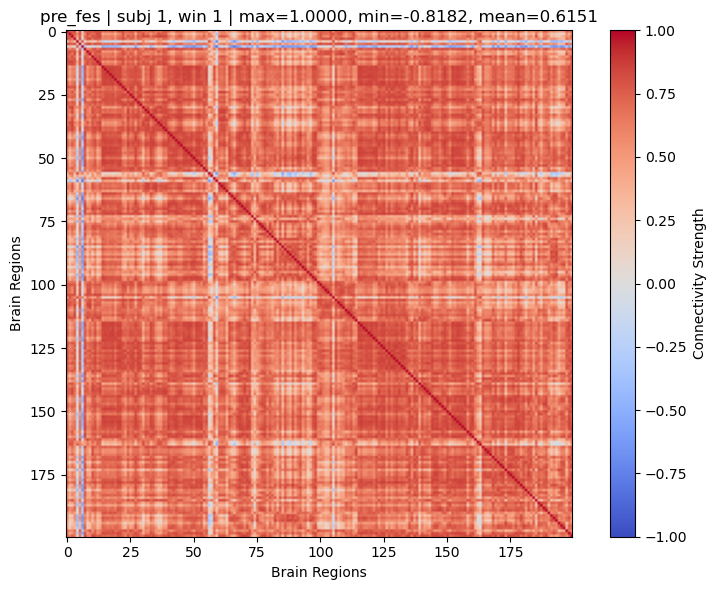

In [40]:
# Summary of FC tensors (subjects x windows x regions x regions)
for g, arr in group_fc_results.items():
    print(f"   {g:>12}: {arr.shape}")

# ----- Choose which group / subject / window to visualize -----
g_idx = 0   # index into cfg.groups (0-based). Change this to pick a different group.
subj  = 1   # subject number (min is 1). Change this to pick a different subject.
win   = 1   # window number  (min is 1). Change this to pick a different window.
# --------------------------------------------------------------

if len(group_fc_results) > 0:
    # Validate group index
    if not (0 <= g_idx < len(cfg.groups)):
        print(f"   Invalid g_idx={g_idx}. Valid range is 0..{len(cfg.groups)-1}.")
    else:
        g0 = cfg.groups[g_idx]
        if g0 in group_fc_results and group_fc_results[g0].size > 0:
            arr = group_fc_results[g0]
            n_subj, n_win, r1, r2 = arr.shape

            # Validate subj/win (1-based)
            if not (1 <= subj <= n_subj):
                print(f"   Invalid subj={subj}. Valid range for [{g0}] is 1..{n_subj}.")
            elif not (1 <= win <= n_win):
                print(f"   Invalid win={win}. Valid range for [{g0}] is 1..{n_win}.")
            else:
                subj_idx = subj - 1
                win_idx  = win  - 1

                FC_example = arr[subj_idx, win_idx]  # (R, R)
                print(f"\n   Example from [{g0}] subj {subj}, win {win} -> FC stats: "
                      f"min={np.min(FC_example):.4f}, max={np.max(FC_example):.4f}, mean={np.mean(FC_example):.4f}")

                fig, ax = plt.subplots(figsize=(8, 6))
                im = ax.imshow(FC_example, cmap='coolwarm', vmin=-1, vmax=1)
                ax.set_title(f'{g0} | subj {subj}, win {win} | max={np.max(FC_example):.4f}, min={np.min(FC_example):.4f}, mean={np.mean(FC_example):.4f}')
                ax.set_xlabel('Brain Regions')
                ax.set_ylabel('Brain Regions')
                fig.colorbar(im, ax=ax, label='Connectivity Strength')
                plt.tight_layout()
                plt.show()
        else:
            print("   No FC results available to visualize for the selected group.")
else:
    print("   group_fc_results is empty.")


        pre_fes: (7, 396, 200, 200)
       pre_nfes: (5, 396, 200, 200)
       post_fes: (7, 396, 200, 200)
      post_nfes: (5, 396, 200, 200)


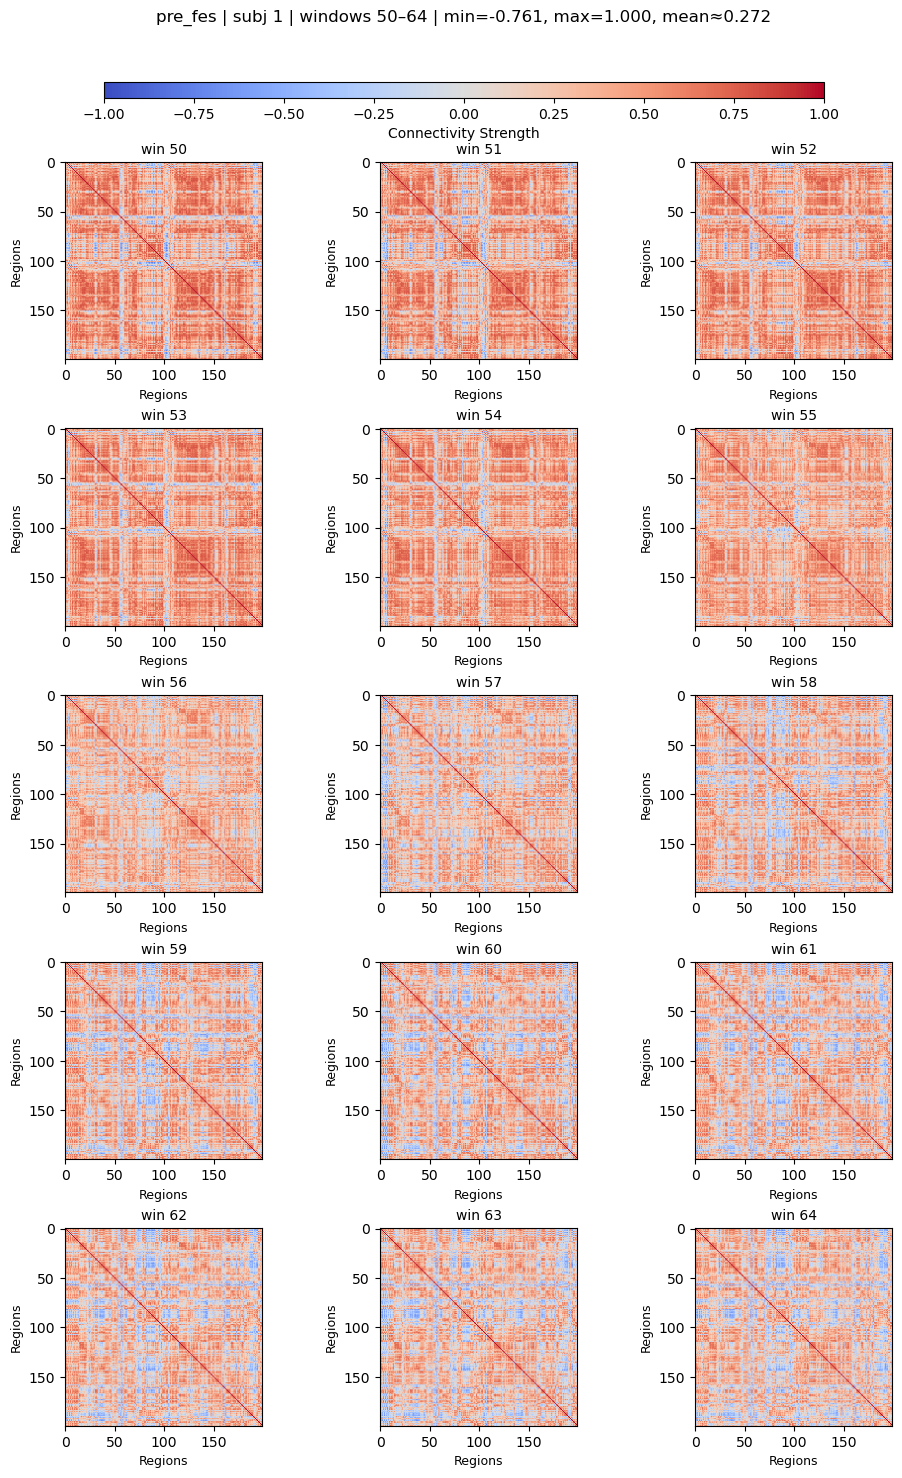

In [41]:
for g, arr in group_fc_results.items():
    print(f"   {g:>12}: {arr.shape}")

g_idx = 0   
subj  = 1   
win   = 50   
# Grid layout
n_cols = 3  
n_rows = 5 # window-based FCs
# --------------------------------------------------------------

if len(group_fc_results) > 0:
    # Validate group index
    if not (0 <= g_idx < len(cfg.groups)):
        print(f"   Invalid g_idx={g_idx}. Valid range is 0..{len(cfg.groups)-1}.")
    else:
        g0 = cfg.groups[g_idx]
        if g0 in group_fc_results and group_fc_results[g0].size > 0:
            arr = group_fc_results[g0]
            n_subj, n_win, r1, r2 = arr.shape

            # Validate subj/win (1-based)
            if not (1 <= subj <= n_subj):
                print(f"   Invalid subj={subj}. Valid range for [{g0}] is 1..{n_subj}.")
            elif not (1 <= win <= n_win):
                print(f"   Invalid win={win}. Valid range for [{g0}] is 1..{n_win}.")
            else:
                subj_idx = subj - 1
                start_w  = win - 1
                max_panels = n_cols * n_rows
                end_w   = min(start_w + max_panels, n_win)  # exclusive
                k = end_w - start_w
                if k <= 0:
                    print(f"   No windows available from win={win} in [{g0}].")
                else:
                    # Prepare figure grid
                    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4.0, n_rows*3.2))
                    axes = axes.ravel()

                    # Track global stats over displayed windows
                    mins, maxs, means = [], [], []

                    im = None
                    for i in range(n_cols * n_rows):
                        ax = axes[i]
                        if i < k:
                            w_idx = start_w + i
                            FC_example = arr[subj_idx, w_idx]  # (R, R)
                            mins.append(np.min(FC_example))
                            maxs.append(np.max(FC_example))
                            means.append(np.mean(FC_example))

                            im = ax.imshow(FC_example, cmap='coolwarm', vmin=-1, vmax=1)
                            ax.set_title(f'win {w_idx+1}', fontsize=10)
                            ax.set_xlabel('Regions', fontsize=9)
                            ax.set_ylabel('Regions', fontsize=9)
                        else:
                            ax.axis('off')

                    # One shared colorbar for all subplots
                    if im is not None:
                        #cbar = fig.colorbar(im, ax=axes.tolist(), location='top', orientation='horizontal', fraction=0.02, pad=0.01, label='Connectivity Strength')
                        
                        cax = fig.add_axes([0.2, 0.94, 0.6, 0.01])  # [left, bottom, width, height] in figure coords
                        cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
                        cbar.set_label('Connectivity Strength')

                        # leave space for the top bar and tighten subplot spacing if needed
                        fig.subplots_adjust(top=0.90, wspace=0.05, hspace=0.35)

                        
                    # Suptitle with context and summary stats
                    if k > 0:
                        fig.suptitle(
                            f'{g0} | subj {subj} | windows {start_w+1}–{start_w+k} '
                            f'| min={np.min(mins):.3f}, max={np.max(maxs):.3f}, mean≈{np.mean(means):.3f}',
                            fontsize=12, y=0.995
                        )
                    #plt.tight_layout(rect=[0, 0, 1, 0.98])
                    plt.show()
        else:
            print("   No FC results available to visualize for the selected group.")
else:
    print("   group_fc_results is empty.")


Any NaN?  []
Kept 396 / 396 windows (removed 0 with NaN/Inf).
Subject 4 in [post_nfes]: averaged over 396 windows.
Mean FC stats -> mean=0.1622, std=0.1854, min=-0.3976, max=1.0000


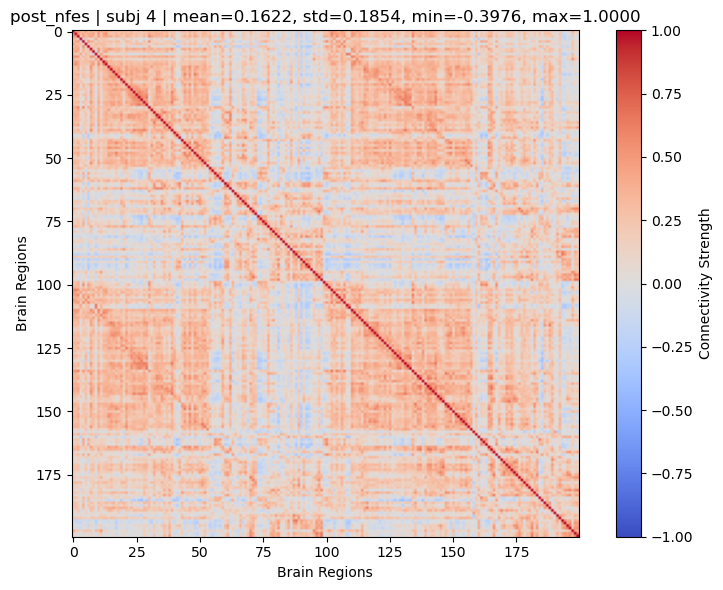

In [42]:
# --- Subject-level mean FC across all windows (200x200) ---
# Uses the group/subject selections : g_idx, subj
g_idx = 3   
subj  = 4 
if len(group_fc_results) > 0:
    if not (0 <= g_idx < len(cfg.groups)):
        print(f"Invalid g_idx={g_idx}. Valid range is 0..{len(cfg.groups)-1}.")
    else:
        g0 = cfg.groups[g_idx]
        if g0 in group_fc_results and group_fc_results[g0].size > 0:
            arr = group_fc_results[g0]             # (subjects, windows, R, R)
            n_subj, n_win, r1, r2 = arr.shape
            if not (1 <= subj <= n_subj):
                print(f"Invalid subj={subj}. Valid range for [{g0}] is 1..{n_subj}.")
            else:
                subj_idx = subj - 1
                subj_fc_windows = arr[subj_idx]    # (n_win, R, R)
                
                print("Any NaN? ", np.where(np.isnan(subj_fc_windows).any(axis=(1, 2)))[0])
                
                subj_fc_windows = arr[subj_idx]  # (n_win, R, R)

                valid_mask = np.isfinite(subj_fc_windows).all(axis=(1, 2))  # keep windows with all finite values
                clean_windows = subj_fc_windows[valid_mask]

                if clean_windows.size == 0:
                    raise ValueError("All windows contain NaN/Inf; cannot compute mean FC.")

                print(f"Kept {clean_windows.shape[0]} / {subj_fc_windows.shape[0]} windows (removed {(~valid_mask).sum()} with NaN/Inf).")

                subj_mean_FC = clean_windows.mean(axis=0)  # (R, R)
                
                #subj_mean_FC = subj_fc_windows.mean(axis=0)  # (R, R)

                # Stats on the averaged FC matrix
                m_mean = float(np.mean(subj_mean_FC))
                m_std  = float(np.std(subj_mean_FC))
                m_min  = float(np.min(subj_mean_FC))
                m_max  = float(np.max(subj_mean_FC))

                print(f"Subject {subj} in [{g0}]: averaged over {n_win} windows.")
                print(f"Mean FC stats -> mean={m_mean:.4f}, std={m_std:.4f}, min={m_min:.4f}, max={m_max:.4f}")

                fig, ax = plt.subplots(figsize=(8, 6))
                im = ax.imshow(subj_mean_FC, cmap='coolwarm', vmin=-1, vmax=1)
                ax.set_title(
                    f'{g0} | subj {subj} | mean={m_mean:.4f}, std={m_std:.4f}, '
                    f'min={m_min:.4f}, max={m_max:.4f}',
                    fontsize=12, pad=6
                )
                ax.set_xlabel('Brain Regions')
                ax.set_ylabel('Brain Regions')
                # Top-centered horizontal colorbar
                #cbar = fig.colorbar(im, ax=ax, orientation='horizontal', location='top', pad=0.02, shrink=0.85)
                #cbar.set_label('Connectivity Strength')
                fig.colorbar(im, ax=ax, label='Connectivity Strength')
                fig.subplots_adjust(top=0.88)
                plt.tight_layout()
                plt.show()
        else:
            print("No FC results available for the selected group.")
else:
    print("group_fc_results is empty.")


In [43]:
has_nan = np.isnan(subj_mean_FC).any()
print("Any NaN? ", has_nan)

Any NaN?  False


## 11. Save outputs for Multi-layer community detection algorithm

In [44]:
# Save correlations to .mat with ALL WINDOWS (concatenated) per group
# For each group variable corr_<group>: shape = (subjects*windows, regions, regions)

corr_path = '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/'

if 'group_fc_results' not in globals() or len(group_fc_results) == 0:
    print("No FC results available to save")
else:
    os.makedirs(corr_path, exist_ok=True)

    corr_data = {}
    meta = {
        'groups': np.array(list(group_fc_results.keys()), dtype=object),
        'regions': np.array([200], dtype=np.int32),
        'note': np.array(["Each var corr_<group> has shape (subjects*windows, regions, regions)."], dtype=object),
        'index_info': np.array(["idx_map_<group> rows: [subject_index_0based, window_index_0based]"], dtype=object),
    }

    for g, arr in group_fc_results.items():  # arr: (subjects, windows, R, R)
        # Sanitize group name for MATLAB variable rules
        safe_g = ''.join(ch if (ch.isalnum() or ch == '_') else '_' for ch in g)
        if not safe_g or not safe_g[0].isalpha():
            safe_g = f"grp_{safe_g}"

        S, W, R1, R2 = arr.shape
        assert R1 == R2 == 200, f"Unexpected region size for {g}: {(R1, R2)}"

        # Flatten subjects x windows -> (S*W, R, R)
        windows_all = arr.reshape(S * W, R1, R2).astype(np.float32)
        var_name = f"corr_{safe_g}"
        corr_data[var_name] = windows_all

        # Optional: provide an index map to recover (subject, window) for each row
        # Shape: (S*W, 2) with columns [subject_idx_0based, window_idx_0based]
        idx_rows = np.repeat(np.arange(S), W)
        idx_cols = np.tile(np.arange(W), S)
        corr_data[f"idx_map_{safe_g}"] = np.column_stack([idx_rows, idx_cols]).astype(np.int32)

        print(f"Prepared {var_name}: {windows_all.shape}  (subjects*windows, regions, regions) "
              f"from original {arr.shape}")

    # Add optional metadata for convenience
    corr_data['__meta__'] = meta

    out_file = os.path.join(corr_path, "corr_all_groups_1tr_v2.mat")
    savemat(out_file, corr_data)
    print(f"\nSaved MATLAB file with {sum(k.startswith('corr_') for k in corr_data)} group variables "
          f"(+ idx_map_* and __meta__) -> {out_file}")


Prepared corr_pre_fes: (2772, 200, 200)  (subjects*windows, regions, regions) from original (7, 396, 200, 200)
Prepared corr_pre_nfes: (1980, 200, 200)  (subjects*windows, regions, regions) from original (5, 396, 200, 200)
Prepared corr_post_fes: (2772, 200, 200)  (subjects*windows, regions, regions) from original (7, 396, 200, 200)
Prepared corr_post_nfes: (1980, 200, 200)  (subjects*windows, regions, regions) from original (5, 396, 200, 200)

Saved MATLAB file with 4 group variables (+ idx_map_* and __meta__) -> /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/corr_all_groups_1tr_v2.mat


In [45]:
# Save correlations to .mat with ALL WINDOWS (concatenated) per group
# For each group variable corr_<group>: shape = (subjects*windows, regions, regions)

corr_path = '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/'

if 'group_fc_results' not in globals() or len(group_fc_results) == 0:
    print("No FC results available to save")
else:
    os.makedirs(corr_path, exist_ok=True)

    # --- Pass 1: build per-group payloads (and print shapes) ---
    per_group_payload = {}
    for g, arr in group_fc_results.items():  # arr: (subjects, windows, R, R)
        # Sanitize group name for MATLAB variable rules
        safe_g = ''.join(ch if (ch.isalnum() or ch == '_') else '_' for ch in g)
        if not safe_g or not safe_g[0].isalpha():
            safe_g = f"grp_{safe_g}"

        S, W, R1, R2 = arr.shape
        assert R1 == R2 == 200, f"Unexpected region size for {g}: {(R1, R2)}"

        # Flatten subjects x windows -> (S*W, R, R)
        windows_all = arr.reshape(S * W, R1, R2).astype(np.float32)
        idx_rows = np.repeat(np.arange(S), W)        # subject indices
        idx_cols = np.tile(np.arange(W), S)          # window indices
        idx_map   = np.column_stack([idx_rows, idx_cols]).astype(np.int32)

        # Store a per-group dict we can reuse for any save option
        per_group_payload[g] = {
            f'corr_{safe_g}': windows_all,
            f'idx_map_{safe_g}': idx_map,
            '__meta__': {
                'group': np.array([g], dtype=object),
                'regions': np.array([200], dtype=np.int32),
                'note': np.array(["corr_* has shape (subjects*windows, regions, regions)"], dtype=object),
                'index_info': np.array(["idx_map_* rows: [subject_index_0based, window_index_0based]"], dtype=object),
                'shape_original': np.array([S, W, R1, R2], dtype=np.int32),
            }
        }

        print(f"Prepared corr_{safe_g}: {windows_all.shape}  (subjects*windows, regions, regions) "
              f"from original {arr.shape}")

    # --- Option A: 4 separate files (one per group) ---
    for g, payload in per_group_payload.items():
        safe_g = list(payload.keys())[0].replace('corr_', '')  # recover sanitized group token
        out_file = os.path.join(corr_path, f"corr_{safe_g}_1tr_windows.mat")
        savemat(out_file, payload)
        print(f"Saved per-group file -> {out_file}")

    # --- Option B: 2 combined files (FES vs Passive/NFES) ---
    # Detect groups by name keys you used: 'pre_fes','post_fes','pre_nfes','post_nfes'
    fes_groups     = [k for k in per_group_payload.keys() if 'fes' in k and 'nfes' not in k]
    passive_groups = [k for k in per_group_payload.keys() if 'nfes' in k]

    # Build combined dicts
    fes_payload = {}
    for g in fes_groups:
        for k, v in per_group_payload[g].items():
            fes_payload[k] = v
    fes_payload['__meta__'] = {
        'groups': np.array(fes_groups, dtype=object),
        'regions': np.array([200], dtype=np.int32),
        'note': np.array(["Each corr_* = (subjects*windows, regions, regions)"], dtype=object),
        'index_info': np.array(["idx_map_* rows: [subject_index_0based, window_index_0based]"], dtype=object),
    }
    out_fes = os.path.join(corr_path, "corr_FES_1tr_windows.mat")
    savemat(out_fes, fes_payload)
    print(f"Saved combined FES file -> {out_fes}")

    passive_payload = {}
    for g in passive_groups:
        for k, v in per_group_payload[g].items():
            passive_payload[k] = v
    passive_payload['__meta__'] = {
        'groups': np.array(passive_groups, dtype=object),
        'regions': np.array([200], dtype=np.int32),
        'note': np.array(["Each corr_* = (subjects*windows, regions, regions)"], dtype=object),
        'index_info': np.array(["idx_map_* rows: [subject_index_0based, window_index_0based]"], dtype=object),
    }
    out_passive = os.path.join(corr_path, "corr_Passive_1tr_windows.mat")
    savemat(out_passive, passive_payload)
    print(f"Saved combined Passive/NFES file -> {out_passive}")

    # --- Option C: single file with all four groups (your original behavior) ---
    all_payload = {}
    for g, payload in per_group_payload.items():
        for k, v in payload.items():
            if k != '__meta__':
                all_payload[k] = v
    all_payload['__meta__'] = {
        'groups': np.array(list(per_group_payload.keys()), dtype=object),
        'regions': np.array([200], dtype=np.int32),
        'note': np.array(["Each corr_* = (subjects*windows, regions, regions)"], dtype=object),
        'index_info': np.array(["idx_map_* rows: [subject_index_0based, window_index_0based]"], dtype=object),
    }
    out_all = os.path.join(corr_path, "corr_all_groups_1tr_windows.mat")
    savemat(out_all, all_payload)
    print(f"Saved single file with all groups -> {out_all}")


Prepared corr_pre_fes: (2772, 200, 200)  (subjects*windows, regions, regions) from original (7, 396, 200, 200)
Prepared corr_pre_nfes: (1980, 200, 200)  (subjects*windows, regions, regions) from original (5, 396, 200, 200)
Prepared corr_post_fes: (2772, 200, 200)  (subjects*windows, regions, regions) from original (7, 396, 200, 200)
Prepared corr_post_nfes: (1980, 200, 200)  (subjects*windows, regions, regions) from original (5, 396, 200, 200)
Saved per-group file -> /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/corr_pre_fes_1tr_windows.mat
Saved per-group file -> /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/corr_pre_nfes_1tr_windows.mat
Saved per-group file -> /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/corr_post_fes_1tr_windows.mat
Saved per-group file -> /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/corr_post_nfes_1tr_windows.mat
Saved combined FES file -> /Users/ismaila/Documents/



### 🔁 Python ↔ MATLAB ↔ Python Workflow




## 12. Load MATLAB v7.3 (HDF5) file after Multi-layer community label assign.

In [56]:
# # Load MATLAB v7.3 (HDF5)
# mat_path = '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var/S_indivi_wind_v2_.mat'
# with h5py.File(mat_path, 'r') as f:
#     S_g = f['N_all_g'][()]  # expected (200, 1200) or (1200, 200)
# S_g = np.squeeze(np.asarray(S_g))

# # Fix orientation: ensure shape = (200, 1200)
# total_cols = 1200
# if S_g.ndim == 2 and S_g.shape == (total_cols, 200):
#     S_g = S_g.T
# assert S_g.shape == (200, total_cols), f"Unexpected shape {S_g.shape}; expected (200, {total_cols})"
# print("S_g shape (fixed):", S_g.shape)

# # ---- Split into 24 communities (subjects), each with 50 consecutive windows -> (200 x 50) ----
# wins_per_subj = 50 #50 396
# assert total_cols % wins_per_subj == 0, f"{total_cols} not divisible by {wins_per_subj}"
# n_subjects = total_cols // wins_per_subj
# assert n_subjects == 24, f"Expected 24 subjects, got {n_subjects}"

# communities = [S_g[:, i*wins_per_subj:(i+1)*wins_per_subj] for i in range(n_subjects)]
# # subjects = [N_all_g[:, i*wins_per_subj:(i+1)*wins_per_subj] for i in range(n_subjects)]
# print("24 communities (subjects), each 200x50:")
# for i, C in enumerate(communities, 1):
#     print(f"  subj {i:02d}: {C.shape}")


In [60]:

# ----------------------------
# Paths (edit as needed)
# ----------------------------
# Base directory where MATLAB saved the per-group outputs
BASE_DIR = Path("/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var")

# Tags & filenames must match your MATLAB saves
TAGS = ["prefes", "prenfes", "postfes", "postnfes"]
FNAME_TEMPLATE = "mlcd_{tag}_1tr_wins.mat"

# Expected number of nodes (rows). Adjust if your N != 200.
N_EXPECTED = 200

def read_var(f: h5py.File, varname: str):
    """Read a variable from a v7.3 MAT file using h5py, with a friendly error if missing."""
    if varname not in f:
        # Show what's available to help debugging
        keys = list(f.keys())
        raise KeyError(f"Variable '{varname}' not found. Available keys: {keys}")
    arr = f[varname][()]
    return np.squeeze(np.asarray(arr))

def fix_orientation(mat: np.ndarray, n_expected: int) -> np.ndarray:
    """
    Ensure matrix is shaped (N, T). If we see (T, N), transpose.
    If already (N, T), keep as-is.
    """
    if mat.ndim != 2:
        raise ValueError(f"Expected 2D matrix, got shape {mat.shape}")
    r, c = mat.shape
    if r == n_expected:
        return mat  # already (N, T)
    if c == n_expected:
        return mat.T  # was (T, N), make (N, T)
    # As a fallback, if one dim equals N, orient accordingly:
    if n_expected in (r, c):
        return mat if r == n_expected else mat.T
    # Otherwise, warn explicitly
    raise ValueError(f"Neither dimension matches N={n_expected}. Got {mat.shape}")

# ----------------------------
# Load N_all_g from each group file and concatenate
# ----------------------------
group_tags = ['prefes', 'prenfes', 'postfes', 'postnfes']
N_all_g_list = []

for tag in group_tags:
    mat_path = BASE_DIR / FNAME_TEMPLATE.format(tag=tag)
    
    if not mat_path.exists():
        raise FileNotFoundError(f"File not found: {mat_path}")
    
    with h5py.File(mat_path, 'r') as f:
        # Read N_all_g_<tag>
        varname = f'N_all_g_{tag}'
        N_all_g_tag = read_var(f, varname)
        
        # Fix orientation to (N, T)
        N_all_g_tag = fix_orientation(N_all_g_tag, N_EXPECTED)
        N_all_g_list.append(N_all_g_tag)
        
        print(f"Loaded {varname}: {N_all_g_tag.shape}")

# Concatenate all groups along columns (time/windows dimension)
N_all_g = np.concatenate(N_all_g_list, axis=1)
print(f"\nCombined N_all_g shape: {N_all_g.shape}")

# ----------------------------
# Split into subjects then 4 groups
# ----------------------------
N, total_cols = N_all_g.shape
assert N == 200, f"Expected 200 regions (rows), got {N}"

n_subjects = 24  # per your draft spec
assert total_cols % n_subjects == 0, f"{total_cols} not divisible by {n_subjects}"
wins_per_subj = total_cols // n_subjects
print(f"Inferred wins_per_subj: {wins_per_subj}")

# Slice into [subject_0, subject_1, ..., subject_23], each (200, wins_per_subj)
subjects = [N_all_g[:, i*wins_per_subj:(i+1)*wins_per_subj] for i in range(n_subjects)]

print(f"\n{n_subjects} subjects extracted:")
for i, subj in enumerate(subjects, 1):
    print(f"  subj {i:02d}: {subj.shape}")

# By default, assume 6 subjects per group in the order you ran
subjects_per_group = n_subjects // 4
assert subjects_per_group * 4 == n_subjects, "Subjects not divisible into 4 equal groups."

group_slices = {
    'prefes':   (0, subjects_per_group),                          # subjects 0..5
    'prenfes':  (subjects_per_group, 2*subjects_per_group),       # subjects 6..11
    'postfes':  (2*subjects_per_group, 3*subjects_per_group),     # subjects 12..17
    'postnfes': (3*subjects_per_group, 4*subjects_per_group),     # subjects 18..23
}

# ----------------------------
# Helper: load S_g, Q_g, comm_num_all_g from each per-group file
# ----------------------------
def load_group_metrics(tag):
    """
    Load S_g_<tag>, Q_g_<tag>, comm_num_all_g_<tag> from mlcd_<tag>_1tr_wins.mat (v7.3/HDF5).
    Returns dict with available items (numpy arrays/scalars).
    """
    out = {}
    mat_path = BASE_DIR / FNAME_TEMPLATE.format(tag=tag)
    
    if not mat_path.exists():
        print(f"  [warn] Per-group file not found: {mat_path}")
        return out

    wanted = {
        f'S_g_{tag}': 'S_g',
        f'Q_g_{tag}': 'Q_g',
        f'comm_num_all_g_{tag}': 'comm_num_all_g'
    }
    
    try:
        with h5py.File(mat_path, 'r') as f:
            for k_raw, k_std in wanted.items():
                try:
                    arr = read_var(f, k_raw)
                    # Fix orientation for S_g if needed
                    if k_std == 'S_g' and arr.ndim == 2:
                        arr = fix_orientation(arr, N_EXPECTED)
                    out[k_std] = arr
                except KeyError:
                    print(f"  [info] Variable '{k_raw}' not found in {mat_path}")
    except Exception as e:
        print(f"  [error] Could not read {mat_path}: {e}")
    
    return out

# ----------------------------
# Build per-group N_all_g and print metrics
# ----------------------------
groups = {}

for tag in group_tags:
    start, end = group_slices[tag]
    # Concatenate subjects for this group along columns
    N_all_g_grp = np.concatenate(subjects[start:end], axis=1)
    groups[tag] = {'N_all_g': N_all_g_grp}

    print(f"\n{'='*50}")
    print(f"=== Group: {tag} ===")
    print(f"{'='*50}") 

    # Load and print S_g, Q_g, comm_num_all_g saved by MATLAB for this tag
    other = load_group_metrics(tag)
    
    if 'S_g' in other:
        print(f"S_g shape: {other['S_g'].shape}")
        groups[tag]['S_g'] = other['S_g']
    else:
        print("S_g: (not available in file)")

    if 'Q_g' in other:
        Q_val = other['Q_g']
        print(f"Q_g: {Q_val:.6f}")
        groups[tag]['Q_g'] = Q_val
        
        #print(f"Q_g: {other['Q_g']}")
        #groups[tag]['Q_g'] = other['Q_g']
    else:
        print("Q_g: (not available in file)")

    if 'comm_num_all_g' in other:
        print(f"comm_num_all_g: {other['comm_num_all_g']}")
        groups[tag]['comm_num_all_g'] = other['comm_num_all_g']
    else:
        print("comm_num_all_g: (not available in file)")

print("\n" + "="*50)
print("Processing complete!")
print("="*50)

# ----------------------------
# Access example:
# groups['prefes']['N_all_g']  -> (200, wins_per_subj*6)
# groups['prefes']['S_g']      -> if loaded, (200, T_g_prefes)
# groups['prefes']['Q_g']      -> if loaded, scalar modularity for prefes
# groups['prefes']['comm_num_all_g'] -> if loaded, max community number
# ----------------------------
# subjects = [N_all_g[:, i*wins_per_subj:(i+1)*wins_per_subj] for i in range(n_subjects)]
communities = subjects

Loaded N_all_g_prefes: (200, 2772)
Loaded N_all_g_prenfes: (200, 1980)
Loaded N_all_g_postfes: (200, 2772)
Loaded N_all_g_postnfes: (200, 1980)

Combined N_all_g shape: (200, 9504)
Inferred wins_per_subj: 396

24 subjects extracted:
  subj 01: (200, 396)
  subj 02: (200, 396)
  subj 03: (200, 396)
  subj 04: (200, 396)
  subj 05: (200, 396)
  subj 06: (200, 396)
  subj 07: (200, 396)
  subj 08: (200, 396)
  subj 09: (200, 396)
  subj 10: (200, 396)
  subj 11: (200, 396)
  subj 12: (200, 396)
  subj 13: (200, 396)
  subj 14: (200, 396)
  subj 15: (200, 396)
  subj 16: (200, 396)
  subj 17: (200, 396)
  subj 18: (200, 396)
  subj 19: (200, 396)
  subj 20: (200, 396)
  subj 21: (200, 396)
  subj 22: (200, 396)
  subj 23: (200, 396)
  subj 24: (200, 396)

=== Group: prefes ===
S_g shape: (200, 396)
Q_g: 0.926877
comm_num_all_g: 9.0

=== Group: prenfes ===
S_g shape: (200, 396)
Q_g: 0.950656
comm_num_all_g: 8.0

=== Group: postfes ===
S_g shape: (200, 396)
Q_g: 0.924623
comm_num_all_g: 11.0

In [75]:
# ----------------------------
# Paths (edit as needed)
# ----------------------------
# Base directory where MATLAB saved the per-group outputs
BASE_DIR = Path("/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var")

# Tags & filenames must match your MATLAB saves
TAGS = ["prefes", "prenfes", "postfes", "postnfes"]
FNAME_TEMPLATE = "mlcd_{tag}_1tr_wins_v1.mat"

# Expected number of nodes (rows). Adjust if your N != 200.
N_EXPECTED = 200

def read_var(f: h5py.File, varname: str):
    """Read a variable from a v7.3 MAT file using h5py, with a friendly error if missing."""
    if varname not in f:
        # Show what's available to help debugging
        keys = list(f.keys())
        raise KeyError(f"Variable '{varname}' not found. Available keys: {keys}")
    arr = f[varname][()]
    return np.squeeze(np.asarray(arr))

def fix_orientation(mat: np.ndarray, n_expected: int) -> np.ndarray:
    """
    Ensure matrix is shaped (N, T). If we see (T, N), transpose.
    If already (N, T), keep as-is.
    """
    if mat.ndim != 2:
        raise ValueError(f"Expected 2D matrix, got shape {mat.shape}")
    r, c = mat.shape
    if r == n_expected:
        return mat  # already (N, T)
    if c == n_expected:
        return mat.T  # was (T, N), make (N, T)
    # As a fallback, if one dim equals N, orient accordingly:
    if n_expected in (r, c):
        return mat if r == n_expected else mat.T
    # Otherwise, warn explicitly
    raise ValueError(f"Neither dimension matches N={n_expected}. Got {mat.shape}")

# ----------------------------
# Load S_g from each group file
# ----------------------------
group_tags = ['prefes', 'prenfes', 'postfes', 'postnfes']
S_g_list = []

print("===== LOADING S_g FROM MATLAB FILES =====\n")

for tag in group_tags:
    mat_path = BASE_DIR / FNAME_TEMPLATE.format(tag=tag)
    
    if not mat_path.exists():
        raise FileNotFoundError(f"File not found: {mat_path}")
    
    with h5py.File(mat_path, 'r') as f:
        # Read S_g_<tag>
        varname = f'S_g_{tag}'
        S_g_tag = read_var(f, varname)
        
        # Fix orientation to (N, T)
        S_g_tag = fix_orientation(S_g_tag, N_EXPECTED)
        S_g_list.append(S_g_tag)
        
        print(f"Loaded {varname}: {S_g_tag.shape}")

# Extract individual S_g arrays
S_g1 = S_g_list[0]  # PreFES
S_g2 = S_g_list[1]  # PreNFES
S_g3 = S_g_list[2]  # PostFES
S_g4 = S_g_list[3]  # PostNFES

print(f"\n{'='*50}")
print("S_g Arrays Loaded:")
print(f"{'='*50}")
print(f"S_g1 (PreFES):   {S_g1.shape}")
print(f"S_g2 (PreNFES):  {S_g2.shape}")
print(f"S_g3 (PostFES):  {S_g3.shape}")
print(f"S_g4 (PostNFES): {S_g4.shape}")

# ----------------------------
# Load Q_g and comm_num_all_g for each group
# ----------------------------
print(f"\n{'='*50}")
print("LOADING ADDITIONAL METRICS")
print(f"{'='*50}\n")

groups = {}

for i, tag in enumerate(group_tags):
    mat_path = BASE_DIR / FNAME_TEMPLATE.format(tag=tag)
    
    groups[tag] = {'S_g': S_g_list[i]}
    
    with h5py.File(mat_path, 'r') as f:
        # Load Q_g
        try:
            Q_g = read_var(f, f'Q_g_{tag}')
            groups[tag]['Q_g'] = float(Q_g)
            print(f"[{tag}] Q_g: {float(Q_g):.6f}")
        except KeyError:
            print(f"[{tag}] Q_g: (not available)")
        
        # Load comm_num_all_g
        try:
            comm_num = read_var(f, f'comm_num_all_g_{tag}')
            groups[tag]['comm_num_all_g'] = int(comm_num)
            print(f"[{tag}] comm_num_all_g: {int(comm_num)}")
        except KeyError:
            print(f"[{tag}] comm_num_all_g: (not available)")
    
    print()

print(f"{'='*50}")
print("Processing complete!")
print(f"{'='*50}\n")

# ----------------------------
# Access examples:
# S_g1, S_g2, S_g3, S_g4 - individual S_g arrays
# groups['prefes']['S_g']  -> (200, 396) - community assignments per window
# groups['prefes']['Q_g']  -> scalar modularity value
# groups['prefes']['comm_num_all_g'] -> max community number
# ----------------------------

print("Available data:")
print(f"  S_g1 (PreFES):   shape {S_g1.shape}, unique communities: {len(np.unique(S_g1))}")
print(f"  S_g2 (PreNFES):  shape {S_g2.shape}, unique communities: {len(np.unique(S_g2))}")
print(f"  S_g3 (PostFES):  shape {S_g3.shape}, unique communities: {len(np.unique(S_g3))}")
print(f"  S_g4 (PostNFES): shape {S_g4.shape}, unique communities: {len(np.unique(S_g4))}")


===== LOADING S_g FROM MATLAB FILES =====

Loaded S_g_prefes: (200, 396)
Loaded S_g_prenfes: (200, 396)
Loaded S_g_postfes: (200, 396)
Loaded S_g_postnfes: (200, 396)

S_g Arrays Loaded:
S_g1 (PreFES):   (200, 396)
S_g2 (PreNFES):  (200, 396)
S_g3 (PostFES):  (200, 396)
S_g4 (PostNFES): (200, 396)

LOADING ADDITIONAL METRICS

[prefes] Q_g: 0.926877
[prefes] comm_num_all_g: 9

[prenfes] Q_g: 0.950656
[prenfes] comm_num_all_g: 8

[postfes] Q_g: 0.924623
[postfes] comm_num_all_g: 11

[postnfes] Q_g: 0.980941
[postnfes] comm_num_all_g: 7

Processing complete!

Available data:
  S_g1 (PreFES):   shape (200, 396), unique communities: 9
  S_g2 (PreNFES):  shape (200, 396), unique communities: 8
  S_g3 (PostFES):  shape (200, 396), unique communities: 11
  S_g4 (PostNFES): shape (200, 396), unique communities: 7


## 13. Derive fMRI Outcome Measures (across windows)

In [76]:
# Make sure `communities` is the 24-subject list (each array 200x50), not the 4-group list
assert isinstance(communities, list), "`communities` must be a list"
assert all(isinstance(C, np.ndarray) and C.shape[0] == 200 for C in communities), \
       "Each communities[s] must be an array with 200 rows (nodes)."

# The actual number of sets found (should be 24), not for study group=4
n_set = len(communities)
print(f"Detected {n_set} sets (expected 24).")

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=1)
# labels = atlas.labels.astype('U')  # convert array of bytes to array of strings

labels = np.array(atlas.labels[1:]).astype('U')  # Skip the first 'Background' label

# group_label = ['Pre FES', 'Post FES', 'Pre NFES']
# create static communities (networks' labels)
networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
static_communities = np.zeros((200,), dtype=int)
# find networks in atlas.labels and assign a label[1-7] to each
for i, network in enumerate(networks):
    idx = np.array([network in s for s in labels], dtype=bool)
    static_communities[idx] = i + 1  # 1-7

allegiance, integration, recruitment = [], [], []
allegiance_coarse = []

# Find index where elements change value in static_communities array
pivot = np.where(static_communities[:-1] != static_communities[1:])[0]
pivot = np.concatenate([pivot, [199]])

def create_coarse_allegiance(allegiance):
    allegiance_coarse_lr = np.zeros((14, 14))
    p1, q1 = 0, 0
    for i, p2 in enumerate(pivot):
        for j, q2 in enumerate(pivot):
            allegiance_coarse_lr[i, j] = np.nanmean(allegiance[p1:p2+1, q1:q2+1])
            q1 = q2 + 1
        p1 = p2 + 1
        q1 = 0
    # If you have an array of shape (K * M, K * N), you can transform it into something of shape (K * K, M, N) using reshape and transpose
    allegiance_coarse = np.mean(allegiance_coarse_lr.reshape(2, 7, 2, 7).transpose(0, 2, 1, 3).reshape(-1, 7, 7), axis=0)
    return allegiance_coarse

for s in range(n_set):
    C = communities[s]  # expected shape: (200, 50)

    A = communitymeasures.allegiance(C)                       # (200, 200)
    I = communitymeasures.integration(C, static_communities)  # (200,)
    R = communitymeasures.recruitment(C, static_communities)  # (200,)

    allegiance.append(A)
    integration.append(I)
    recruitment.append(R)
    allegiance_coarse.append(create_coarse_allegiance(A))

    print(f"Set {s+1}: allegiance={A.shape}, recruitment={R.shape}, integration={I.shape}")


Detected 24 sets (expected 24).
[fetch_atlas_schaefer_2018] Dataset found in /Users/ismaila/nilearn_data/schaefer_2018
Set 1: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 2: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 3: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 4: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 5: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 6: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 7: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 8: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 9: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 10: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 11: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 12: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 13: allegiance=(200, 200), recruitment=(200,),

In [77]:
s_idx = 3                 # 0-based; e.g., the 4th set out of 24
A = allegiance[s_idx]     # (200, 200) allegiance matrix for set s_idx
I = integration[s_idx]    # (200,)   integration vector (per node)
R = recruitment[s_idx]    # (200,)   recruitment vector (per node)

print(f'Shape of index {s_idx}: allegiance-{A.shape}; recruitment-{R.shape}; integration-{I.shape} ')

Shape of index 3: allegiance-(200, 200); recruitment-(200,); integration-(200,) 


## 14. RC, IC, AM Visualization

[cFES-Pre] Allegiance[set 6 | subj 6][22,18] = 1.0000


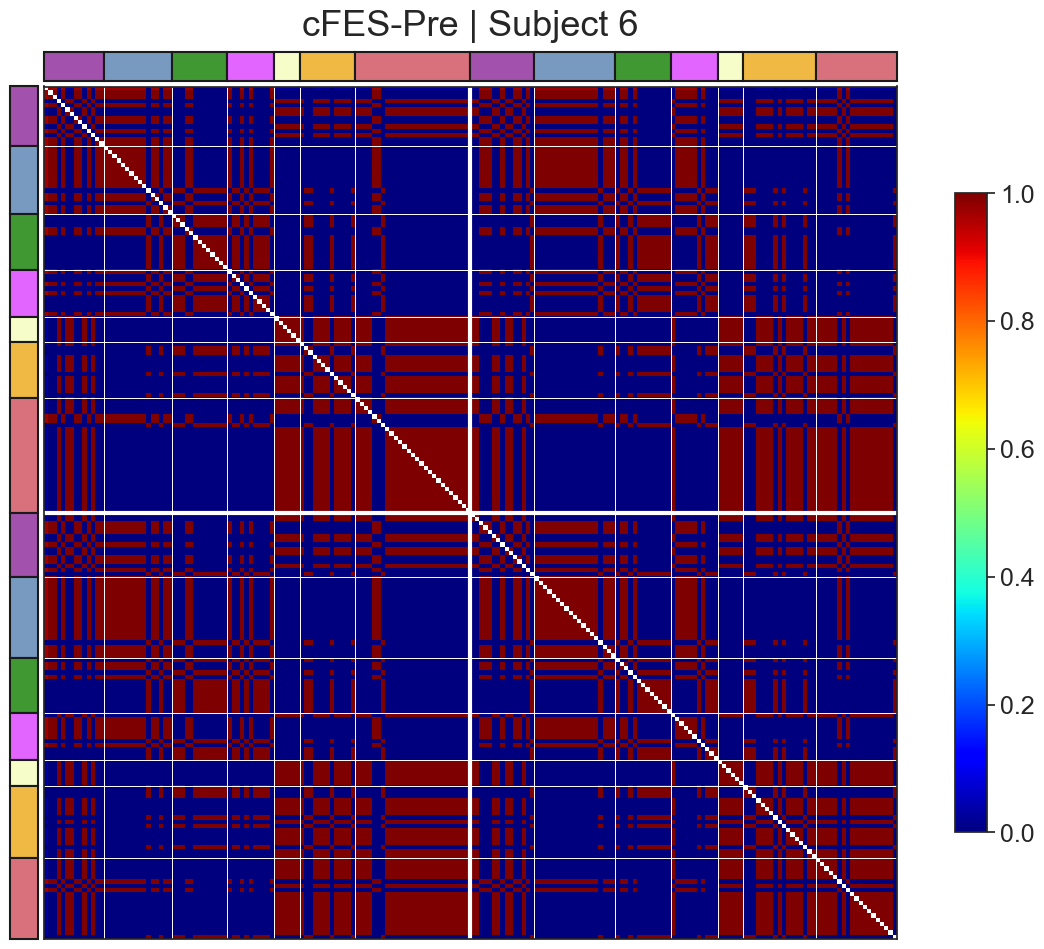

In [78]:
# --- Select a subject set (1..24), then PRINT a single allegiance entry and plot the matrix ---

# Selection (edit these)
s_idx = 5   # 0-based subject set index (0..23)

i, j = 22, 18  # node indices (0-based) whose allegiance value you want to print
# Trying to detect the allegiance value of two brain regions (nodes) by their positions in the matrix between 
# those two nodes—i.e., how consistently they’re assigned to the same community across windows for that subject/set.
# Valid indices are 0…199 for a 200×200 matrix.
# Note: A_sel[i, i] (diagonal) is typically 1, and the matrix is symmetric (A_sel[i, j] == A_sel[j, i]).

# ---- Map set index -> group label (per your ranges) ----
set_num = s_idx + 1  # convert to 1-based for readability
if 1 <= set_num <= 6:
    grp_label, grp_start = 'cFES-Pre', 1
elif 7 <= set_num <= 11:
    grp_label, grp_start = 'Cycling-Pre', 7
elif 12 <= set_num <= 18:
    grp_label, grp_start = 'cFES-Post', 12
elif 19 <= set_num <= 23:  # note: 24 will fall into "(Unlabeled)" per your ranges
    grp_label, grp_start = 'Cycling-Post', 19
else:
    grp_label, grp_start = '(Unlabeled)', set_num
subj_in_group = set_num - grp_start + 1

# Slice allegiance matrix (200x200) for that subject set (no window selection)
A_sel = allegiance[s_idx]  # expected shape: (200, 200)

# Print the requested allegiance entry
print(f"[{grp_label}] Allegiance[set {set_num} | subj {subj_in_group}][{i},{j}] = {A_sel[i, j]:.4f}")

# -------- Plot (keep original structure; swap allegiance[0] -> A_sel) --------
cmap='jet'
f = plt.figure(figsize=(15,11))
plt.matshow(A_sel, fignum=f.number, vmin=0, vmax=1, cmap=cmap)
plt.title(f"{grp_label} | Subject {set_num}", fontsize=26, y=1.05)
plt.xticks([13.5, 29.5, 42.5, 53.5, 59.5, 72.5, 99.5, 114.5, 133.5, 146.5, 157.5, 163.5, 180.5])
plt.yticks([13.5, 29.5, 42.5, 53.5, 59.5, 72.5, 99.5, 114.5, 133.5, 146.5, 157.5, 163.5, 180.5])
cb = plt.colorbar(shrink=0.75)
cb.ax.tick_params(labelsize=18)
plt.axvline(x=100-0.5, color='white', linewidth=3)
plt.axhline(y=100-0.5, color='white', linewidth=3)
plt.grid(color='white', linestyle='-', linewidth=0.7)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labeltop=False, labelleft=False)

xmin, xmax, ymin, ymax = plt.axis()
h = (ymax-ymin)/30; space = h/5; i_marker = ymax + space
plt.gca().add_patch(patches.Rectangle((-0.5, i_marker), width=13.5+0.5, height=h, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((13.5, i_marker), width=29.5-13.5, height=h, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((29.5, i_marker), width=42.5-29.5, height=h, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((42.5, i_marker), width=53.5-42.5, height=h, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((53.5, i_marker), width=59.5-53.5, height=h, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((59.5, i_marker), width=72.5-59.5, height=h, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((72.5, i_marker), width=99.5-72.5, height=h, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((99.5, i_marker), width=114.5-99.5, height=h, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((114.5, i_marker), width=133.5-114.5, height=h, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((133.5, i_marker), width=146.5-133.5, height=h, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((146.5, i_marker), width=157.5-146.5, height=h, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((157.5, i_marker), width=163.5-157.5, height=h, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((163.5, i_marker), width=180.5-163.5, height=h, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((180.5, i_marker), width=199.5-180.5, height=h, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))

w = (ymax-ymin)/30; i_marker2 = ymax
plt.gca().add_patch(patches.Rectangle((i_marker2+space, -0.5), width=w, height=13.5+0.5, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 13.5), width=w, height=29.5-13.5, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 29.5), width=w, height=42.5-29.5, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 42.5), width=w, height=53.5-42.5, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 53.5), width=w, height=59.5-53.5, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 59.5), width=w, height=72.5-59.5, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 72.5), width=w, height=99.5-72.5, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 99.5), width=w, height=114.5-99.5, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 114.5), width=w, height=133.5-114.5, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 133.5), width=w, height=146.5-133.5, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 146.5), width=w, height=157.5-146.5, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 157.5), width=w, height=163.5-157.5, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 163.5), width=w, height=180.5-163.5, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 180.5), width=w, height=199.5-180.5, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))

plt.show()


Subj 2 cFES-Pre vs Subj 14 cFES-Post; Node [18,20] = 1.0000 vs 1.0000


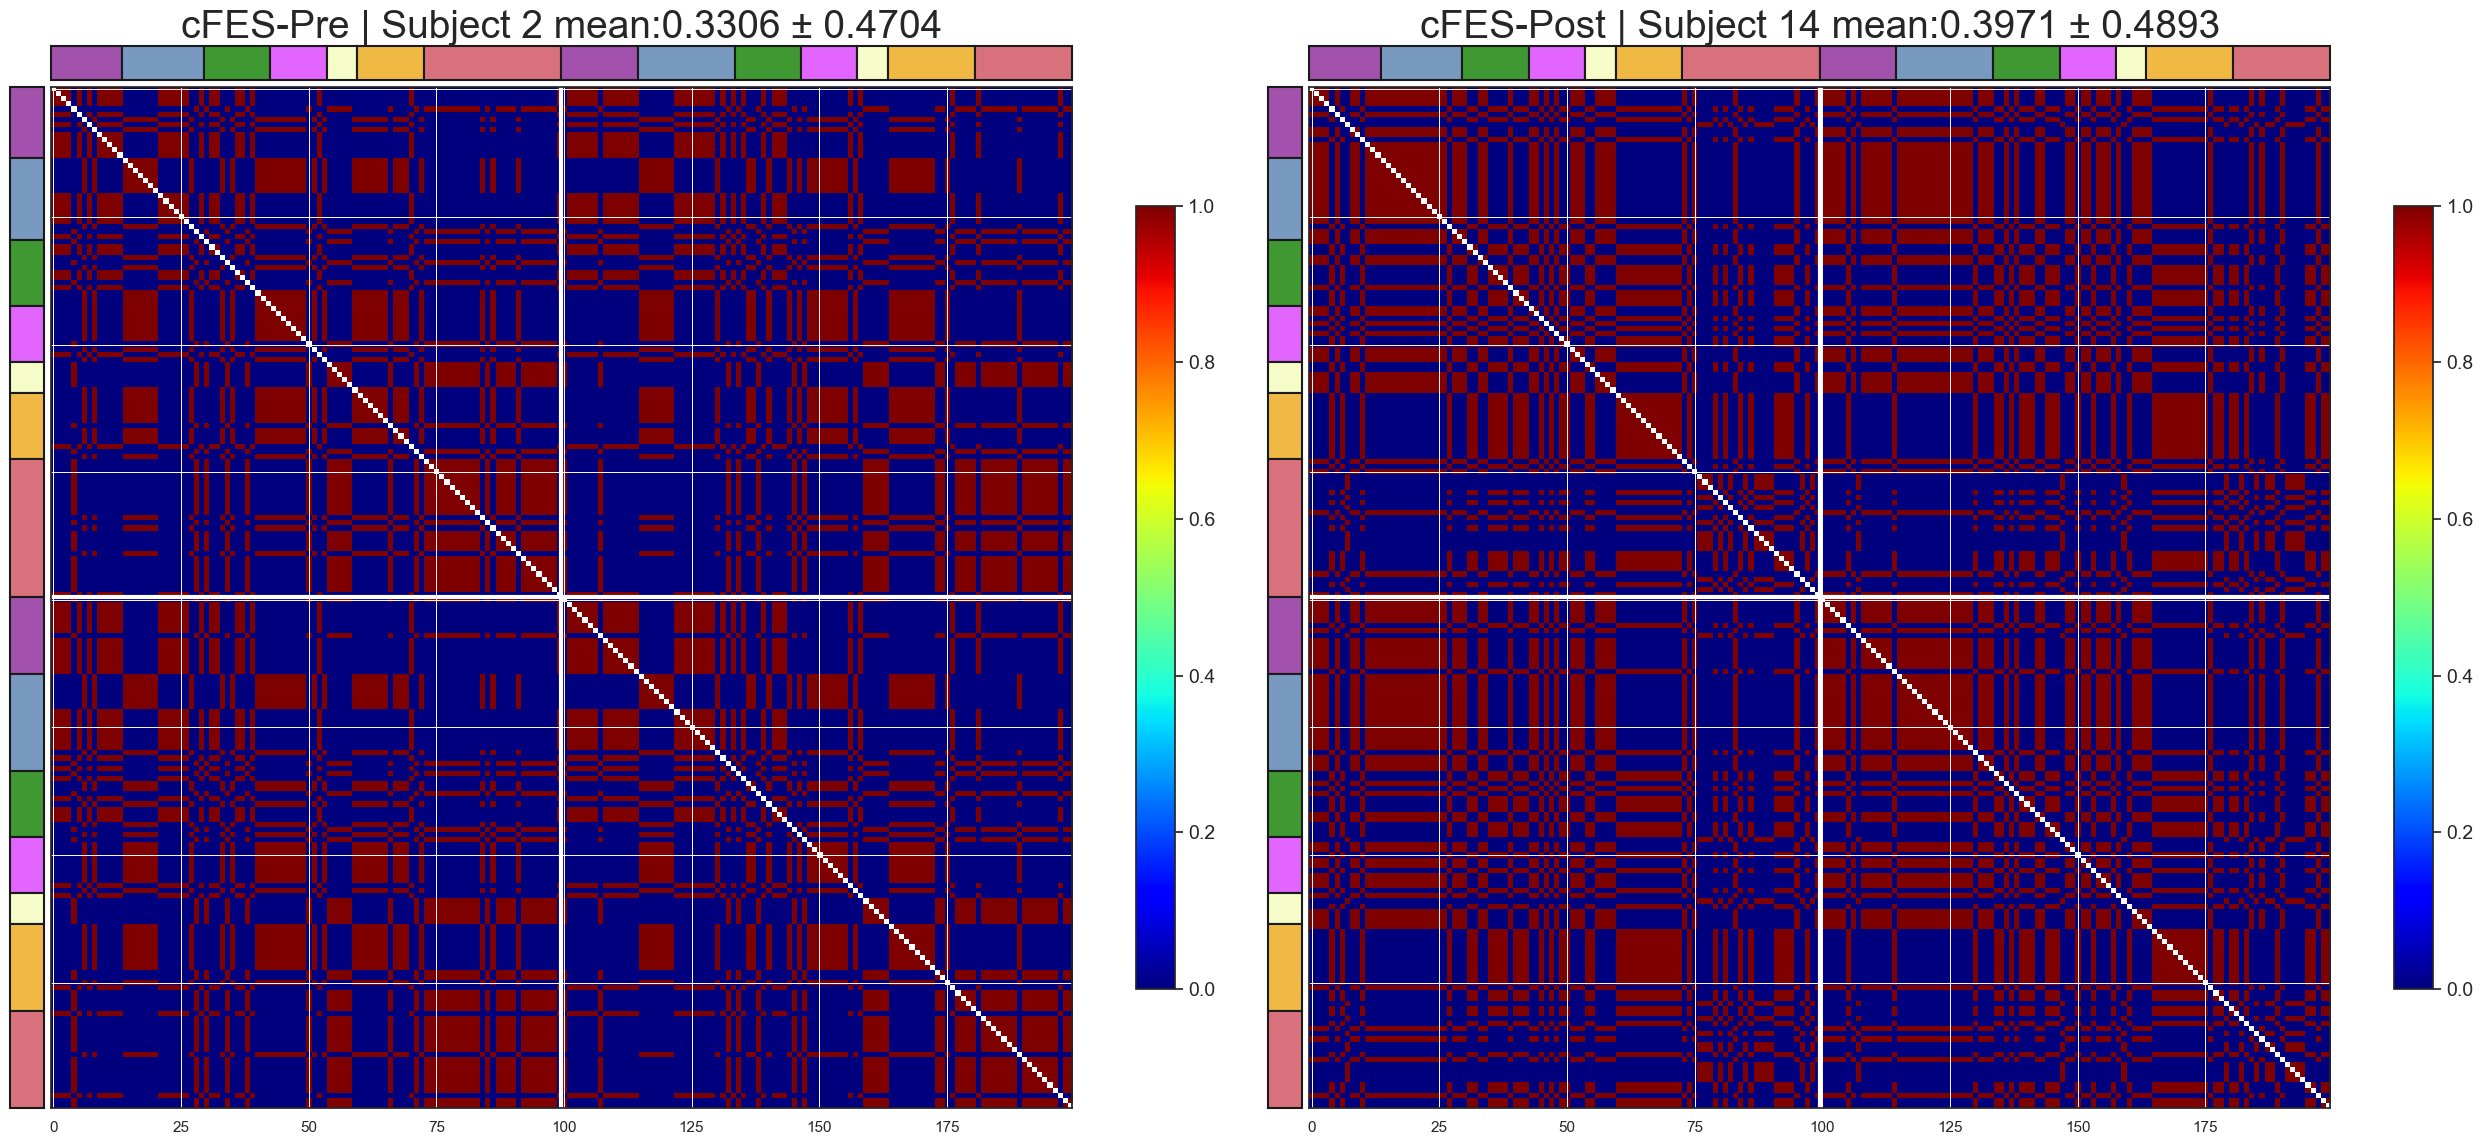

In [79]:
# --- Select two specific subjects (one PreFES, one PostFES) and plot Recruitment vs Integration ---

# 0 - based
s_idx1 = 1   # e.g choose one from 0..3..6 (PreFES) 7..9..11 (PreNFES) 1st, 4th, 7th; 1st, 3rd, 5th
s_idx2 = 13  # e.g choose one from 12..15..18 (PostFES) 19..21..23 (PostNFES)

# 1 - based
# 1–7: cFES-Pre (pre_fes)
# 8–12: Cycling-Pre (pre_nfes)
# 13–19: cFES-Post (post_fes)
# 20–24: Cycling-Post (post_nfes)

i, j = 18, 20  # node indices (0-based) whose allegiance value I want to print

def _set_to_group(s_idx: int):
    set_num = s_idx + 1  # 1-based for readability
    if 1 <= set_num <= 7:
        grp_label, grp_start = 'cFES-Pre', 1
    elif 8 <= set_num <= 12:
        grp_label, grp_start = 'Cycling-Pre', 8
    elif 13 <= set_num <= 19:
        grp_label, grp_start = 'cFES-Post', 13
    elif 20 <= set_num <= 24:
        grp_label, grp_start = 'Cycling-Post', 20
    else:
        grp_label, grp_start = '(Other)', set_num
    subj_in_group = set_num - grp_start + 1
    return grp_label, set_num, subj_in_group

# Slice allegiance matrices (200x200) for both subject sets (no window selection)
A_sel1 = allegiance[s_idx1]
A_sel2 = allegiance[s_idx2]

# Print the requested allegiance entries
grp_label1, set_num1, subj_in_group1 = _set_to_group(s_idx1)
grp_label2, set_num2, subj_in_group2 = _set_to_group(s_idx2)

print(f"Subj {set_num1} {grp_label1} vs Subj {set_num2} {grp_label2}; Node [{i},{j}] = {A_sel1[i, j]:.4f} vs {A_sel2[i, j]:.4f}")
# print(f"[{grp_label2}] Allegiance[Subj {set_num2}] [{i},{j}] = {A_sel2[i, j]:.4f}")

# -------- Plot two matrices in 1 row × 2 columns --------
cmap = 'jet'
fig, axes = plt.subplots(1, 2, figsize=(26, 11))

for ax, A_sel, (grp_label, set_num, subj_in_group) in zip(
    axes,
    [A_sel1, A_sel2],
    [ (grp_label1, set_num1, subj_in_group1), (grp_label2, set_num2, subj_in_group2) ]
):
    im = ax.imshow(A_sel, vmin=0, vmax=1, cmap=cmap)
    A_sel = np.nan_to_num(A_sel, nan=0)
    ax.set_title(f"{grp_label} | Subject {set_num} mean:{np.mean(A_sel):.4f} ± {np.std(A_sel):.4f}", fontsize=28, pad=35)
    #ax.set_title(f'cFES-pre\nmean:{np.mean(alg_a):.4f} ± {np.std(alg_a):.4f}', fontsize=26, y=1.04)
    #ax.set_xticks([13.5, 29.5, 42.5, 53.5, 59.5, 72.5, 99.5, 114.5, 133.5, 146.5, 157.5, 163.5, 180.5])
    #ax.set_yticks([13.5, 29.5, 42.5, 53.5, 59.5, 72.5, 99.5, 114.5, 133.5, 146.5, 157.5, 163.5, 180.5])
    cb = fig.colorbar(im, ax=ax, shrink=0.75)
    cb.ax.tick_params(labelsize=14)
    ax.axvline(x=100-0.5, color='white', linewidth=3)
    ax.axhline(y=100-0.5, color='white', linewidth=3)
    ax.grid(color='white', linestyle='-', linewidth=0.7)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labeltop=False, labelleft=False)

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    h = (ymax - ymin) / 30.0
    space = h / 5.0
    i_marker = ymax + space

    # Top color bars for networks (X axis)
    ax.add_patch(patches.Rectangle((-0.5, i_marker), width=13.5+0.5,  height=h, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((13.5, i_marker), width=29.5-13.5, height=h, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((29.5, i_marker), width=42.5-29.5, height=h, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((42.5, i_marker), width=53.5-42.5, height=h, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((53.5, i_marker), width=59.5-53.5, height=h, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((59.5, i_marker), width=72.5-59.5, height=h, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((72.5, i_marker), width=99.5-72.5, height=h, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((99.5, i_marker), width=114.5-99.5, height=h, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((114.5, i_marker), width=133.5-114.5, height=h, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((133.5, i_marker), width=146.5-133.5, height=h, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((146.5, i_marker), width=157.5-146.5, height=h, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((157.5, i_marker), width=163.5-157.5, height=h, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((163.5, i_marker), width=180.5-163.5, height=h, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((180.5, i_marker), width=199.5-180.5, height=h, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))

    # Right-side color bars for networks (Y axis)
    w = (ymax - ymin) / 30.0
    i_marker2 = ymax
    ax.add_patch(patches.Rectangle((i_marker2 + space, -0.5),  width=w, height=13.5+0.5,  facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 13.5),  width=w, height=29.5-13.5, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 29.5),  width=w, height=42.5-29.5, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 42.5),  width=w, height=53.5-42.5, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 53.5),  width=w, height=59.5-53.5, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 59.5),  width=w, height=72.5-59.5, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 72.5),  width=w, height=99.5-72.5, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 99.5),  width=w, height=114.5-99.5, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 114.5), width=w, height=133.5-114.5, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 133.5), width=w, height=146.5-133.5, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 146.5), width=w, height=157.5-146.5, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 157.5), width=w, height=163.5-157.5, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 163.5), width=w, height=180.5-163.5, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 180.5), width=w, height=199.5-180.5, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))

plt.tight_layout()
plt.show()


In [66]:
def extract_smn_block(alg_a, alg_b, idx1=(14, 30), idx2=(115, 134), verbose=True):
    """
    Extract and stack submatrices from allegiance matrices to form 35x35 SMN matrices.

    Parameters:
    - alg_a, alg_b: Input allegiance matrices (e.g., from pre/post or condition A/B)
    - idx1, idx2: Tuples of (start, end) indices for two brain subregions
    - verbose: Whether to print matrix shapes

    Returns:
    - alg_smn_a, alg_smn_b: Two (35, 35) allegiance submatrices
    """
    i1_start, i1_end = idx1
    i2_start, i2_end = idx2

    def extract_block(matrix):
        s1 = matrix[i1_start:i1_end, i1_start:i1_end]
        s2 = matrix[i1_start:i1_end, i2_start:i2_end]
        s3 = matrix[i2_start:i2_end, i1_start:i1_end]
        s4 = matrix[i2_start:i2_end, i2_start:i2_end]
        top = np.hstack((s1, s2))
        bottom = np.hstack((s3, s4))
        return np.vstack((top, bottom))

    alg_smn_a = extract_block(alg_a)
    alg_smn_b = extract_block(alg_b)

    if verbose:
        print(f"Allegiance SMN : {alg_smn_a.shape} - {alg_smn_b.shape}")

    return alg_smn_a, alg_smn_b

In [67]:
x_alg_SMN_c, z_alg_SMN_c = extract_smn_block(A_sel1, A_sel2)
alg_smn_a = x_alg_SMN_c
alg_smn_b = z_alg_SMN_c

alg_smn_a = np.nan_to_num(alg_smn_a, nan=0)
alg_smn_b = np.nan_to_num(alg_smn_b, nan=0)

Allegiance SMN : (35, 35) - (35, 35)


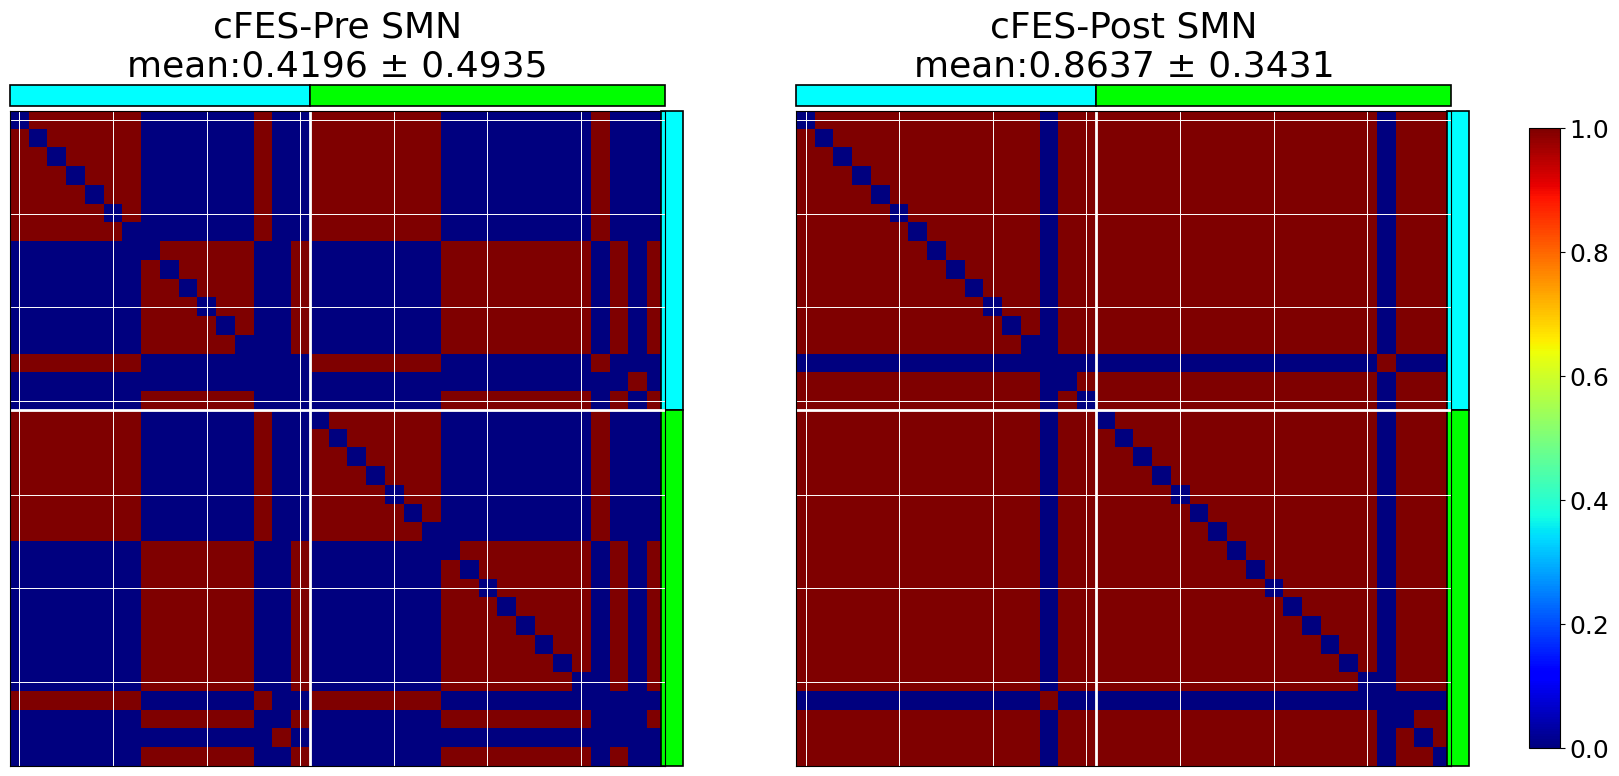

In [68]:
cmap = 'jet'
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot matrices
im1 = axs[0].matshow(alg_smn_a, vmin=0, vmax=1, cmap=cmap)
axs[0].set_title(f'{grp_label1} SMN\nmean:{np.mean(alg_smn_a):.4f} ± {np.std(alg_smn_a):.4f}', fontsize=26, y=1.04)

im2 = axs[1].matshow(alg_smn_b, vmin=0, vmax=1, cmap=cmap)
axs[1].set_title(f'{grp_label2} SMN\nmean:{np.mean(alg_smn_b):.4f} ± {np.std(alg_smn_b):.4f}', fontsize=26, y=1.04)

# Common styling
for ax in axs:
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labeltop=False, labelleft=False)
    ax.grid(color='white', linestyle='-', linewidth=0.7)

    # --- Add top and right side blocks to subdivide 35 into 16 (cyan) + 19 (lemon) ---
    xmin, xmax, ymin, ymax = ax.axis()
    h = (ymax - ymin) / 30.0
    space = h / 5.0
    top_y = ymax + space
    right_x = xmax + space

    # Top bars (over x)
    ax.add_patch(patches.Rectangle((-0.5, top_y), 16, h, facecolor='cyan', edgecolor='k',
                                   linewidth=1.2, clip_on=False))
    ax.add_patch(patches.Rectangle((15.5, top_y), 19, h, facecolor='lime', edgecolor='k',
                                   linewidth=1.2, clip_on=False))

    # Right bars (over y)
    w = (xmax - xmin) / 30.0
    ax.add_patch(patches.Rectangle((right_x, -0.5), w, 16, facecolor='cyan', edgecolor='k',
                                   linewidth=1.2, clip_on=False))
    ax.add_patch(patches.Rectangle((right_x, 15.5), w, 19, facecolor='lime', edgecolor='k',
                                   linewidth=1.2, clip_on=False))

    # Optional: draw separating lines at 16 boundary
    ax.axvline(15.5, color='white', linewidth=2)
    ax.axhline(15.5, color='white', linewidth=2)

# Single colorbar
cbar = fig.colorbar(im2, ax=axs, orientation='vertical', fraction=0.02, shrink=0.85)
cbar.ax.tick_params(labelsize=18)

plt.show()


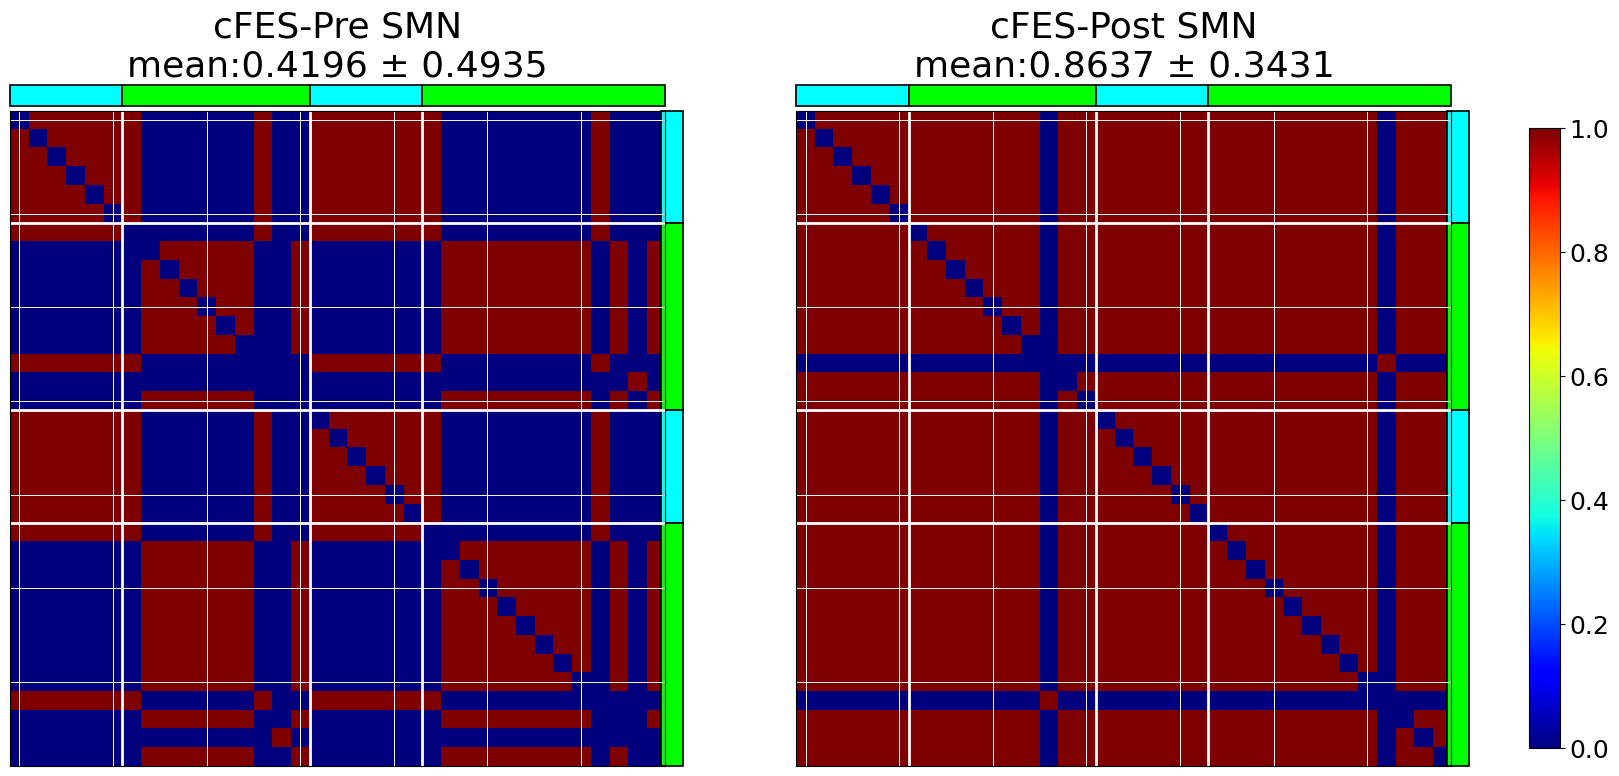

In [69]:
# Modified patches

cmap = 'jet'
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot matrices
im1 = axs[0].matshow(alg_smn_a, vmin=0, vmax=1, cmap=cmap)
axs[0].set_title(f'{grp_label1} SMN\nmean:{np.mean(alg_smn_a):.4f} ± {np.std(alg_smn_a):.4f}', fontsize=26, y=1.04)

im2 = axs[1].matshow(alg_smn_b, vmin=0, vmax=1, cmap=cmap)
axs[1].set_title(f'{grp_label2} SMN\nmean:{np.mean(alg_smn_b):.4f} ± {np.std(alg_smn_b):.4f}', fontsize=26, y=1.04)

# Common styling
for ax in axs:
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labeltop=False, labelleft=False)
    ax.grid(color='white', linestyle='-', linewidth=0.7)

    # ---- Divide into 4 region groups: 6, 10, 6, 13 ----
    group_sizes = [6, 10, 6, 13]
    group_colors = ['cyan', 'lime', 'cyan', 'lime']

    xmin, xmax, ymin, ymax = ax.axis()
    h = (ymax - ymin) / 30.0
    space = h / 5.0
    top_y = ymax + space
    right_x = xmax + space

    # Top bars (horizontal group indicators)
    start_x = -0.5
    for size, color in zip(group_sizes, group_colors):
        ax.add_patch(patches.Rectangle((start_x, top_y), size, h,
                                       facecolor=color, edgecolor='k',
                                       linewidth=1.2, clip_on=False))
        start_x += size

    # Right bars (vertical group indicators)
    w = (xmax - xmin) / 30.0
    start_y = -0.5
    for size, color in zip(group_sizes, group_colors):
        ax.add_patch(patches.Rectangle((right_x, start_y), w, size,
                                       facecolor=color, edgecolor='k',
                                       linewidth=1.2, clip_on=False))
        start_y += size

    # Draw separating lines at boundaries between groups
    boundaries = np.cumsum(group_sizes)[:-1] - 0.5
    for b in boundaries:
        ax.axvline(b, color='white', linewidth=2)
        ax.axhline(b, color='white', linewidth=2)

# Single colorbar
cbar = fig.colorbar(im2, ax=axs, orientation='vertical', fraction=0.02, shrink=0.85)
cbar.ax.tick_params(labelsize=18)

plt.show()


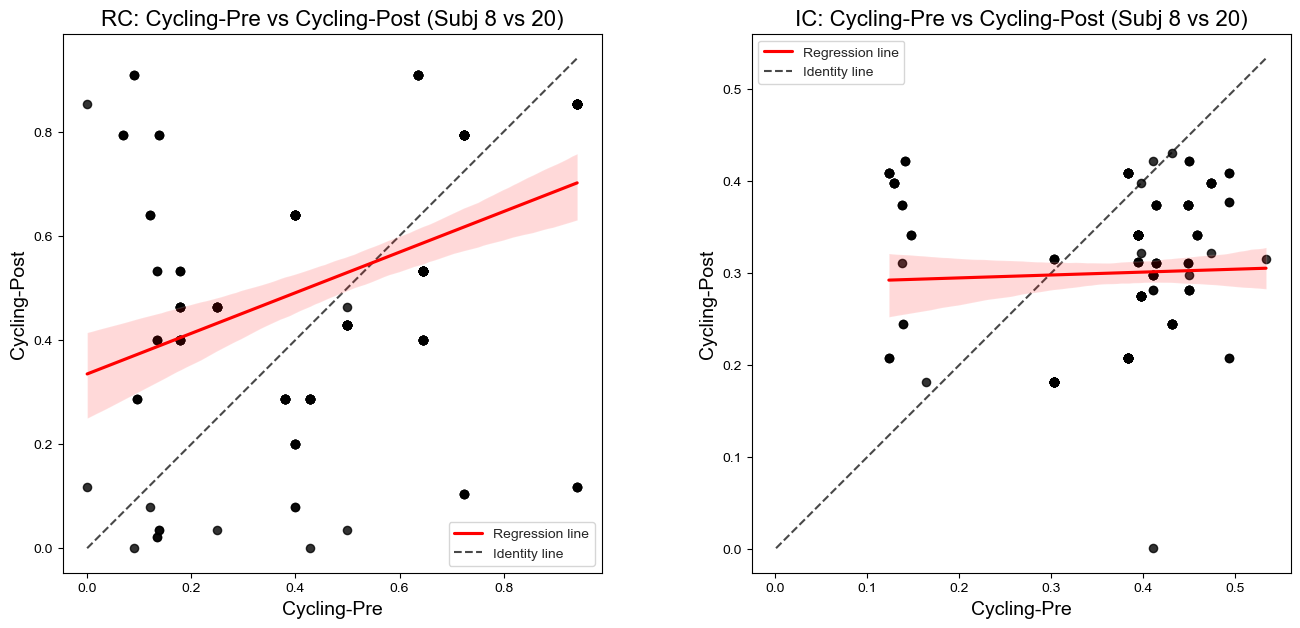

In [70]:
# --- Compare a chosen PreFES subject vs a chosen PostFES subject ---
# Indices of the 24 subject (0-based): 0–6 = PreFES, 7-11= PreNFES, 12–18 = PostFES, 19-23=PostNFES;

# 1–7: cFES-Pre (pre_fes)
# 8–12: Cycling-Pre (pre_nfes)
# 13–19: cFES-Post (post_fes)
# 20–24: Cycling-Post (post_nfes)

# --- Select two specific subjects (one PreFES, one PostFES) and plot Recruitment vs Integration ---
pre_idx  = 7   # e.g choose one from 0..3..6 (PreFES) 7..9..11 (PreNFES) 1st, 4th, 7th; 1st, 3rd, 5th
post_idx = 19  # e.g choose one from 12..15..18 (PostFES) 19..21..23 (PostNFES)

def _grp_label_and_pos(s_idx: int):
    s = s_idx + 1  # 1-based for readability
    if 1 <= s <= 7: return "cFES-Pre", 1, s - 1            # (label, group-start, 0-based subj-in-group)
    if 8 <= s <= 12: return f"Cycling-Pre", 8, s - 8
    if 13 <= s <= 19: return "cFES-Post", 13, s - 13
    if 20 <= s <= 24: return f"Cycling-Post",20, s - 20
    return "(Other)", s, 0

pre_lab, pre_start, pre_subj = _grp_label_and_pos(pre_idx)
post_lab, post_start, post_subj = _grp_label_and_pos(post_idx)

def _clean_xy(x, y):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    m = np.isfinite(x) & np.isfinite(y)
    skipped = np.size(x) - np.count_nonzero(m)
    return x[m], y[m], skipped

def plot_regression(ax, x, y, xlabel, ylabel, title):
    sns.regplot(x=x, y=y, ci=95, scatter_kws={"color": "black", "s": 35},
                line_kws={"color": "red", 'label': 'Regression line'}, ax=ax)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    lims = [min(np.min(x), np.min(y)), max(np.max(x), np.max(y))]
    ax.plot(lims, lims, 'k--', alpha=0.8, zorder=0, label='Identity line')
    ax.set_xlim(lims); ax.set_ylim(lims); ax.axis('square'); ax.legend(loc="best", fontsize=10)


# Prepare figure: 1 row × 2 columns
fig, (ax_rec, ax_int) = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
sns.set(style='white')

# Recruitment: PreFES vs PostFES
xR, yR, skipR = _clean_xy(recruitment[pre_idx], integration[pre_idx]*0 + recruitment[post_idx])  # align shapes; yR from post
plot_regression(
    ax_rec,
    x=xR, y=yR,
    xlabel=f'{pre_lab}',
    ylabel=f'{post_lab}',
    title=f'RC: {pre_lab} vs {post_lab} (Subj {pre_idx+1} vs {post_idx+1})'
)
if skipR > 0:
    ax_rec.text(0.02, 0.02, f"Skipped {skipR} NaN/Inf pairs", transform=ax_rec.transAxes, fontsize=10)

# Integration: PreFES vs PostFES
xI, yI, skipI = _clean_xy(integration[pre_idx], integration[post_idx])
plot_regression(
    ax_int,
    x=xI, y=yI,
    xlabel=f'{pre_lab}',
    ylabel=f'{post_lab}',
    title=f'IC: {pre_lab} vs {post_lab} (Subj {pre_idx+1} vs {post_idx+1})'
)
if skipI > 0:
    ax_int.text(0.02, 0.02, f"Skipped {skipI} NaN/Inf pairs", transform=ax_int.transAxes, fontsize=10)

plt.subplots_adjust(wspace=0.25, hspace=0.1)
plt.show()


In [71]:
# === Save Recruitment, Integration, Allegiance, and Community Labels for ALL 24 Subjects ===
out_dir = '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved'
os.makedirs(out_dir, exist_ok=True)

# Expect:
#   - recruitment: list of 24 arrays, each (200,)
#   - integration: list of 24 arrays, each (200,)
#   - allegiance:  list of 24 arrays, each (200, 200)
#   - communities: list of 24 arrays, each (200, 50)
assert len(recruitment) == 24 and len(integration) == 24 and len(allegiance) == 24 and len(communities) == 24, \
    "Expected 24 subjects in recruitment/integration/allegiance/communities."

# Stack across subjects (first dimension = subjects)
recruitment_all = np.stack(recruitment, axis=0)   # (24, 200)
integration_all = np.stack(integration, axis=0)   # (24, 200)
allegiance_all  = np.stack(allegiance,  axis=0)   # (24, 200, 200)
communities_all = np.stack(communities, axis=0)   # (24, 200, 50)

# Save
np.save(os.path.join(out_dir, 'recruitment_all.npy'), recruitment_all)
np.save(os.path.join(out_dir, 'integration_all.npy'), integration_all)
np.save(os.path.join(out_dir, 'allegiance_all.npy'),  allegiance_all)
np.save(os.path.join(out_dir, 'communities_all.npy'), communities_all)

# Report shapes
print("Saved arrays with shapes:")
print("  recruitment_all :", recruitment_all.shape)  # (24, 200)
print("  integration_all :", integration_all.shape)  # (24, 200)
print("  allegiance_all  :", allegiance_all.shape)   # (24, 200, 200)
print("  communities_all :", communities_all.shape)  # (24, 200, 50)


Saved arrays with shapes:
  recruitment_all : (24, 200)
  integration_all : (24, 200)
  allegiance_all  : (24, 200, 200)
  communities_all : (24, 200, 396)


In [26]:
# Load the data from the consolidated .npy files (24 subjects total)
os.chdir('/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/')

# Recruitment and Integration (subjects × nodes) = (24, 200)
recruitment_all = np.load('recruitment_all.npy')   # (24, 200)
integration_all = np.load('integration_all.npy')   # (24, 200)

# Allegiance (subjects × nodes × nodes) = (24, 200, 200)
allegiance_all  = np.load('allegiance_all.npy')    # (24, 200, 200)

# Community labels (subjects × nodes × windows) = (24, 200, 50)
communities_all = np.load('communities_all.npy')   # (24, 200, 50)

# Print shapes of loaded files
print("recruitment_all shape:", recruitment_all.shape)
print("integration_all shape:", integration_all.shape)
print("allegiance_all  shape:", allegiance_all.shape)
print("communities_all shape:", communities_all.shape)


recruitment_all shape: (24, 200)
integration_all shape: (24, 200)
allegiance_all  shape: (24, 200, 200)
communities_all shape: (24, 200, 396)


In [27]:
def extract_SMN_slices(x_rec, z_rec, x_in, z_in, idx1=(14, 30), idx2=(115, 134)):
    """
    Extracts and concatenates specific slices from 1D arrays (length=200) to isolate SMN.
    Pass per-subject vectors (e.g., recruitment_all[pre_idx], integration_all[pre_idx], ...).
    """
    def concat_slices(arr, idx1, idx2):
        arr = np.asarray(arr).squeeze()
        return np.concatenate((arr[idx1[0]:idx1[1]], arr[idx2[0]:idx2[1]]), axis=0)

    x_rec_SMN = concat_slices(x_rec, idx1, idx2)
    z_rec_SMN = concat_slices(z_rec, idx1, idx2)
    x_in_SMN  = concat_slices(x_in,  idx1, idx2)
    z_in_SMN  = concat_slices(z_in,  idx1, idx2)

    print(f"SMN shape: rec_pre={x_rec_SMN.shape}, rec_post={z_rec_SMN.shape}, "
          f"int_pre={x_in_SMN.shape}, int_post={z_in_SMN.shape}\n")
    return x_rec_SMN, z_rec_SMN, x_in_SMN, z_in_SMN


def extract_smn_block(alg_a, alg_b, idx1=(14, 30), idx2=(115, 134), verbose=True):
    """
    From allegiance matrices (200x200) for two subjects (e.g., pre/post),
    build 35x35 SMN block by stacking LL, LR, RL, RR sub-blocks.
    """
    i1_start, i1_end = idx1
    i2_start, i2_end = idx2

    def extract_block(matrix):
        M = np.asarray(matrix).squeeze()
        s1 = M[i1_start:i1_end, i1_start:i1_end]
        s2 = M[i1_start:i1_end, i2_start:i2_end]
        s3 = M[i2_start:i2_end, i1_start:i1_end]
        s4 = M[i2_start:i2_end, i2_start:i2_end]
        top = np.hstack((s1, s2))
        bottom = np.hstack((s3, s4))
        return np.vstack((top, bottom))

    alg_smn_a = extract_block(alg_a)
    alg_smn_b = extract_block(alg_b)

    if verbose:
        print(f"SMN allegiance blocks: pre={alg_smn_a.shape}, post={alg_smn_b.shape}")
    return alg_smn_a, alg_smn_b


def extract_smn_block1(matrix_a, matrix_b, row_ranges=((14, 30), (115, 134)), label_a="pre", label_b="post"):
    """
    From per-subject matrices with 200 rows (e.g., community labels 200x50),
    stack the two SMN row ranges to get 35xK (K=#columns) per subject.
    """
    A = np.asarray(matrix_a)
    B = np.asarray(matrix_b)

    slice1_a = A[row_ranges[0][0]:row_ranges[0][1], :]
    slice2_a = A[row_ranges[1][0]:row_ranges[1][1], :]
    smn_a = np.vstack((slice1_a, slice2_a))

    slice1_b = B[row_ranges[0][0]:row_ranges[0][1], :]
    slice2_b = B[row_ranges[1][0]:row_ranges[1][1], :]
    smn_b = np.vstack((slice1_b, slice2_b))

    print(f'SMN stacked rows ({label_a},{label_b}) shapes: {smn_a.shape} - {smn_b.shape}')
    return smn_a, smn_b


# ----------------------------
# recruitment_all: (24, 200), integration_all: (24, 200),
# allegiance_all: (24, 200, 200), communities_all: (24, 200, 50)
# ----------------------------

# Choose subject indices (0-based): e.g., pre = 0, post = 11
pre_idx  = 0
post_idx = 11

# 1) Vector slices for SMN (recruitment/integration)
x_rec = recruitment_all[pre_idx]   # (200,)
z_rec = recruitment_all[post_idx]  # (200,)
x_in  = integration_all[pre_idx]   # (200,)
z_in  = integration_all[post_idx]  # (200,)

x_rec_SMN, z_rec_SMN, x_in_SMN, z_in_SMN = extract_SMN_slices(x_rec, z_rec, x_in, z_in)

# 2) Allegiance SMN 35x35 blocks for the same subjects
alg_a = allegiance_all[pre_idx]    # (24th subset later; here single 200x200)
alg_b = allegiance_all[post_idx]
alg_smn_a, alg_smn_b = extract_smn_block(alg_a, alg_b)

# 3) Community-label SMN rows (35 x 50) for the same subjects
mat_a = communities_all[pre_idx]   # (200, 50)
mat_b = communities_all[post_idx]
smn_a, smn_b = extract_smn_block1(mat_a, mat_b, label_a="pre", label_b="post")


# ===== Aggregate SMN outputs across ALL 24 subjects =====
# Use the same functions by passing each subject as both inputs; take the first return.
smn_rec_list, smn_int_list = [], []
smn_alg_list, smn_comm_list = [], []

for s in range(recruitment_all.shape[0]):  # 24 subjects
    # 1) Recruitment/Integration SMN (35,)
    r_vec = recruitment_all[s]
    i_vec = integration_all[s]
    r_smn, _, i_smn, _ = extract_SMN_slices(r_vec, r_vec, i_vec, i_vec)
    smn_rec_list.append(r_smn)          # (35,)
    smn_int_list.append(i_smn)          # (35,)

    # 2) Allegiance SMN (35x35)
    A = allegiance_all[s]
    A_smn, _ = extract_smn_block(A, A, verbose=False)
    smn_alg_list.append(A_smn)          # (35, 35)

    # 3) Community-label SMN (35x50)
    C = communities_all[s]
    C_smn, _ = extract_smn_block1(C, C, label_a=f"sub{s+1}", label_b=f"sub{s+1}")
    smn_comm_list.append(C_smn)         # (35, 50)

# Stack to final arrays
SMN_recruitment  = np.stack(smn_rec_list,  axis=0)   # (24, 35)
SMN_integration  = np.stack(smn_int_list,  axis=0)   # (24, 35)
SMN_allegiance   = np.stack(smn_alg_list,  axis=0)   # (24, 35, 35)
SMN_communities  = np.stack(smn_comm_list, axis=0)   # (24, 35, 50)

print(f"\n*****************************")
print(f"\n\nSMN Community-label shape: {SMN_communities.shape}")
print(f"SMN Allegiance matrix shape : {SMN_allegiance.shape}")
print(f"SMN Recruitment shape: {SMN_recruitment.shape}")
print(f"SMN Integration shape: {SMN_integration.shape}")


SMN shape: rec_pre=(35,), rec_post=(35,), int_pre=(35,), int_post=(35,)

SMN allegiance blocks: pre=(35, 35), post=(35, 35)
SMN stacked rows (pre,post) shapes: (35, 396) - (35, 396)
SMN shape: rec_pre=(35,), rec_post=(35,), int_pre=(35,), int_post=(35,)

SMN stacked rows (sub1,sub1) shapes: (35, 396) - (35, 396)
SMN shape: rec_pre=(35,), rec_post=(35,), int_pre=(35,), int_post=(35,)

SMN stacked rows (sub2,sub2) shapes: (35, 396) - (35, 396)
SMN shape: rec_pre=(35,), rec_post=(35,), int_pre=(35,), int_post=(35,)

SMN stacked rows (sub3,sub3) shapes: (35, 396) - (35, 396)
SMN shape: rec_pre=(35,), rec_post=(35,), int_pre=(35,), int_post=(35,)

SMN stacked rows (sub4,sub4) shapes: (35, 396) - (35, 396)
SMN shape: rec_pre=(35,), rec_post=(35,), int_pre=(35,), int_post=(35,)

SMN stacked rows (sub5,sub5) shapes: (35, 396) - (35, 396)
SMN shape: rec_pre=(35,), rec_post=(35,), int_pre=(35,), int_post=(35,)

SMN stacked rows (sub6,sub6) shapes: (35, 396) - (35, 396)
SMN shape: rec_pre=(35,), 

### 15. Prepare data for Analysis

In [28]:

# If you have region names, replace this with your 35 labels:
SMN_REGION_LABELS = [f"SMN{i}" for i in range(1, 36)]
assert len(SMN_REGION_LABELS) == 35, "Need exactly 35 SMN region labels."

# Output directory
out_dir = '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved'
Path(out_dir).mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------------
# Slot mapping per your description:
#  0–6:   cFES-Pre
#  7–11:  Cycling-Pre
#  12–18: cFES-Post
#  19–23: Cycling-Post
def slot_group_time(idx):
    if 0 <= idx <= 6:   return ("FES", "pre")
    if 7 <= idx <= 11:  return ("Passive", "pre")
    if 12 <= idx <= 18: return ("FES", "post")
    if 19 <= idx <= 23: return ("Passive", "post")
    raise ValueError(f"Bad index {idx}")

def paired_index(idx):
    """Return the index of the paired timepoint for the same participant within the same group."""
    g, t = slot_group_time(idx)
    if g == "FES":
        return idx + 12 if t == "pre" else idx - 12
    else:  # Passive
        return idx + 12 if t == "pre" else idx - 12

# ---------------------------------------------------------------
# LEMS tables (given values)
fes_ids     = [f"FES{i:02d}"     for i in range(1, 8)]  # 7 subjects
passive_ids = [f"Passive{i:02d}" for i in range(1, 6)]  # 5 subjects

lems_pre_fes   = [5, 8, 19, 43, 0, 6, 5]
lems_post_fes  = [8, 11, 17, 45, 0, 14, 6]
lems_pre_pass  = [0, 39, 4, 9, 0]
lems_post_pass = [0, 37, 6, 11, 3]

# Build long LEMS table
lems_rows = []
for sid, v in zip(fes_ids, lems_pre_fes):
    lems_rows.append({"subject_id": sid, "group": "FES", "time": "pre",  "LEMS": v})
for sid, v in zip(fes_ids, lems_post_fes):
    lems_rows.append({"subject_id": sid, "group": "FES", "time": "post", "LEMS": v})
for sid, v in zip(passive_ids, lems_pre_pass):
    lems_rows.append({"subject_id": sid, "group": "Passive", "time": "pre",  "LEMS": v})
for sid, v in zip(passive_ids, lems_post_pass):
    lems_rows.append({"subject_id": sid, "group": "Passive", "time": "post", "LEMS": v})

lems_df = pd.DataFrame(lems_rows, columns=["subject_id", "group", "time", "LEMS"])
assert not lems_df.isna().any().any(), "Missing values in LEMS table."

# ---------------------------------------------------------------
# Helper to build the custom wide sheet for a metric array (24 x 35)
def make_blocked_wide_with_pairs(metric_24x35: np.ndarray, label: str) -> pd.DataFrame:
    """
    Builds 24 blocks (S01..S24). For each block (slot):
      - Column 1: Region
      - Columns 2–3: cFES_Pre, cFES_Post
      - Column 4: "" (blank spacer)
      - Columns 5–6: Cycling_Pre, Cycling_Post
    Each block contains BOTH pre and post values for the slot's group by
    pairing the corresponding indices. An empty row separates blocks.
    """
    assert metric_24x35.shape == (24, 35), f"{label} array must be (24,35)"
    blocks = []
    cols = ["Region", "cFES_Pre", "cFES_Post", "", "Cycling_Pre", "Cycling_Post"]

    for idx in range(24):
        scan_id = f"S{idx+1:02d}"
        group, time = slot_group_time(idx)
        pair_idx = paired_index(idx)

        # Determine indices for pre/post for the same participant (depends on group)
        if group == "FES":
            pre_idx  = idx if time == "pre" else pair_idx
            post_idx = idx if time == "post" else pair_idx
            fes_pre_vals  = metric_24x35[pre_idx,  :]
            fes_post_vals = metric_24x35[post_idx, :]
            cyc_pre_vals = [""] * 35
            cyc_post_vals = [""] * 35
        else:  # Passive
            pre_idx  = idx if time == "pre" else pair_idx
            post_idx = idx if time == "post" else pair_idx
            cyc_pre_vals  = metric_24x35[pre_idx,  :]
            cyc_post_vals = metric_24x35[post_idx, :]
            fes_pre_vals  = [""] * 35
            fes_post_vals = [""] * 35

        # Header row
        header = {c: "" for c in cols}
        header["Region"] = f"SubjectID: {scan_id}  |  Slot: {group}-{time}  |  PairOf: S{pair_idx+1:02d}"
        blocks.append(pd.DataFrame([header], columns=cols))

        # 35 region rows
        rows = pd.DataFrame({
            "Region": SMN_REGION_LABELS,
            "cFES_Pre": fes_pre_vals,
            "cFES_Post": fes_post_vals,
            "": ["" for _ in range(35)],
            "Cycling_Pre": cyc_pre_vals,
            "Cycling_Post": cyc_post_vals
        }, columns=cols)

        blocks.append(rows)
        # Spacer empty row
        blocks.append(pd.DataFrame([[""] * len(cols)], columns=cols))

    out = pd.concat(blocks, ignore_index=True)
    return out

# ---------------------------------------------------------------
# Build RC and IC custom sheets (paired pre/post per block)
RC_wide = make_blocked_wide_with_pairs(SMN_recruitment, label="RC")
IC_wide = make_blocked_wide_with_pairs(SMN_integration, label="IC")

# ---------------------------------------------------------------
# Save as XLSX
rc_path = f"{out_dir}/RC_data.xlsx"
ic_path = f"{out_dir}/IC_data.xlsx"
lems_path = f"{out_dir}/LEMS_data.xlsx"

with pd.ExcelWriter(rc_path) as writer:
    RC_wide.to_excel(writer, index=False, sheet_name="RC_Data")

with pd.ExcelWriter(ic_path) as writer:
    IC_wide.to_excel(writer, index=False, sheet_name="IC_Data")

with pd.ExcelWriter(lems_path) as writer:
    lems_df.to_excel(writer, index=False, sheet_name="LEMS_Data")

print(f"Saved Excel files:\n  {rc_path}\n  {ic_path}\n  {lems_path}")

# ---------------------------------------------------------------
# Summaries
def summarize_metric_xlsx(xlsx_path: str):
    print("\n" + "="*70)
    print(f"SUMMARY: {xlsx_path}")
    print("="*70)
    df = pd.read_excel(xlsx_path)

    # Basic shape
    print(f"Shape: {df.shape}")

    # Detect 24 header rows
    header_mask = df["Region"].fillna("").astype(str).str.startswith("SubjectID:")
    header_count = header_mask.sum()
    print(f"Detected subject blocks (header rows): {header_count} (expected 24)")

    # Ensure each block has 35 region rows following its header (allowing for one spacer after)
    # Count total region rows
    region_rows = (df["Region"].isin(SMN_REGION_LABELS)).sum()
    print(f"Total region rows: {region_rows} (expected 24*35 = {24*35})")

    # Non-empty counts per data column
    for col in ["cFES_Pre", "cFES_Post", "Cycling_Pre", "Cycling_Post"]:
        non_empty = df[col].notna() & (df[col].astype(str).str.len() > 0)
        print(f"Non-empty cells in {col}: {non_empty.sum()}")

    # Additional sanity: in FES blocks, cFES_Pre and cFES_Post should both be filled (35 each),
    # in Passive blocks, Cycling_Pre and Cycling_Post should both be filled.
    # We'll approximate by using the slot label in the header line.
    # Extract block labels
    block_starts = df[header_mask].index.tolist()
    fes_blocks = 0
    passive_blocks = 0
    for i, start_idx in enumerate(block_starts):
        slot_text = str(df.loc[start_idx, "Region"])
        is_fes = "Slot: FES" in slot_text
        block_body = df.iloc[start_idx+1 : start_idx+1+35]
        if is_fes:
            fes_blocks += 1
            assert (block_body["cFES_Pre"].notna() | (block_body["cFES_Pre"].astype(str) != "")).sum() == 35, \
                f"FES block at row {start_idx}: cFES_Pre not fully populated"
            assert (block_body["cFES_Post"].notna() | (block_body["cFES_Post"].astype(str) != "")).sum() == 35, \
                f"FES block at row {start_idx}: cFES_Post not fully populated"
        else:
            passive_blocks += 1
            assert (block_body["Cycling_Pre"].notna() | (block_body["Cycling_Pre"].astype(str) != "")).sum() == 35, \
                f"Passive block at row {start_idx}: Cycling_Pre not fully populated"
            assert (block_body["Cycling_Post"].notna() | (block_body["Cycling_Post"].astype(str) != "")).sum() == 35, \
                f"Passive block at row {start_idx}: Cycling_Post not fully populated"
    print(f"FES blocks: {fes_blocks} (expected 14), Passive blocks: {passive_blocks} (expected 10)")

def summarize_lems_xlsx(xlsx_path: str):
    print("\n" + "="*70)
    print(f"SUMMARY: {xlsx_path}")
    print("="*70)
    df = pd.read_excel(xlsx_path)
    print(f"Shape: {df.shape}")
    print("Columns:", list(df.columns))
    print("Group×Time counts:")
    print(df.groupby(["group", "time"]).size().rename("rows"))
    print("LEMS describe():")
    print(df["LEMS"].describe())

# Print summaries
summarize_metric_xlsx(rc_path)
summarize_metric_xlsx(ic_path)
summarize_lems_xlsx(lems_path)

print("\nAll Excel outputs complete")


Saved Excel files:
  /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/RC_data.xlsx
  /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/IC_data.xlsx
  /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/LEMS_data.xlsx

SUMMARY: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/RC_data.xlsx
Shape: (887, 6)
Detected subject blocks (header rows): 24 (expected 24)
Total region rows: 840 (expected 24*35 = 840)
Non-empty cells in cFES_Pre: 490
Non-empty cells in cFES_Post: 490
Non-empty cells in Cycling_Pre: 350
Non-empty cells in Cycling_Post: 350
FES blocks: 14 (expected 14), Passive blocks: 10 (expected 10)

SUMMARY: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/IC_data.xlsx
Shape: (887, 6)
Detected subject blocks (header rows): 24 (expected 24)
Total region rows: 840 (expected 24*35 = 840)
Non-empty cells in cFES_Pre: 490
Non-empty cells in cFES_Po

### 16. Compute delta RC, IC, LEMS 

In [29]:

# ---------------------------------------------------------------
# Assumed available in memory:
#   SMN_recruitment: (24,35)   # RC
#   SMN_integration: (24,35)   # IC
# Replace with your 35 labels if available:
SMN_REGION_LABELS = [f"SMN{i}" for i in range(1, 36)]
assert len(SMN_REGION_LABELS) == 35, "Need exactly 35 SMN region labels."

out_dir = '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved'
Path(out_dir).mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------------
# Slot mapping per your dataset:
#  0–6:   cFES-Pre
#  7–11:  Cycling-Pre
#  12–18: cFES-Post
#  19–23: Cycling-Post
def slot_group_time(idx):
    if 0 <= idx <= 6:   return ("FES", "pre")
    if 7 <= idx <= 11:  return ("Passive", "pre")
    if 12 <= idx <= 18: return ("FES", "post")
    if 19 <= idx <= 23: return ("Passive", "post")
    raise ValueError(f"Bad index {idx}")

def paired_index(idx):
    """Return the index of the paired timepoint for the same participant within the same group."""
    g, t = slot_group_time(idx)
    return idx + 12 if t == "pre" else idx - 12

# ---------------------------------------------------------------
# LEMS values (given)
fes_ids     = [f"FES{i:02d}"     for i in range(1, 8)]  # 7 subjects
passive_ids = [f"Passive{i:02d}" for i in range(1, 6)]  # 5 subjects

lems_pre_fes   = [5, 8, 19, 43, 0, 6, 5]
lems_post_fes  = [8, 11, 17, 45, 0, 14, 6]
lems_pre_pass  = [0, 39, 4, 9, 0]
lems_post_pass = [0, 37, 6, 11, 3]

# ---------------------------------------------------------------
# Compute Δ matrices per slot (S01..S24): Δ = post - pre for the SAME subject.
def compute_delta_matrix(metric_24x35: np.ndarray, label: str) -> np.ndarray:
    assert metric_24x35.shape == (24, 35), f"{label} must be (24,35)"
    delta = np.zeros_like(metric_24x35, dtype=float)
    for idx in range(24):
        g, t = slot_group_time(idx)
        pre_idx  = idx if t == "pre"  else paired_index(idx)
        post_idx = idx if t == "post" else paired_index(idx)
        delta[idx, :] = metric_24x35[post_idx, :] - metric_24x35[pre_idx, :]
    return delta

# ΔRC, ΔIC per slot
delta_RC_matrix = compute_delta_matrix(SMN_recruitment, "RC")
delta_IC_matrix = compute_delta_matrix(SMN_integration, "IC")

# ---------------------------------------------------------------
# Build wide, blocked Δ tables:
# Columns: [Region, Δ_cFES, "", Region_dup, Δ_Cycling]
def make_delta_wide(delta_24x35: np.ndarray, label: str) -> pd.DataFrame:
    assert delta_24x35.shape == (24, 35), f"{label} delta must be (24,35)"
    cols = ["Region", f"Δ{label}_cFES", "", "Region_dup", f"Δ{label}_Cycling"]
    blocks = []

    for idx in range(24):
        scan_id = f"S{idx+1:02d}"
        group, time = slot_group_time(idx)

        # Header row
        header = {c: "" for c in cols}
        header["Region"] = f"SubjectID: {scan_id}  |  Slot: {group}-{time}  |  PairOf: S{paired_index(idx)+1:02d}"
        blocks.append(pd.DataFrame([header], columns=cols))

        # Body (35 regions)
        body = pd.DataFrame("", index=range(35), columns=cols)
        body["Region"] = SMN_REGION_LABELS
        body["Region_dup"] = SMN_REGION_LABELS

        # Fill only the appropriate Δ column for this slot's group
        values = delta_24x35[idx, :]
        if group == "FES":
            body[f"Δ{label}_cFES"] = values
        else:  # Passive
            body[f"Δ{label}_Cycling"] = values

        blocks.append(body)
        # Spacer empty row
        blocks.append(pd.DataFrame([[""] * len(cols)], columns=cols))

    return pd.concat(blocks, ignore_index=True)

delta_RC_wide = make_delta_wide(delta_RC_matrix, "RC")
delta_IC_wide = make_delta_wide(delta_IC_matrix, "IC")

# ---------------------------------------------------------------
# ΔLEMS = post - pre per subject (7 FES + 5 Passive)
delta_lems_rows = []
for sid, pre, post in zip(fes_ids, lems_pre_fes, lems_post_fes):
    delta_lems_rows.append({"subject_id": sid, "group": "FES", "ΔLEMS": post - pre})
for sid, pre, post in zip(passive_ids, lems_pre_pass, lems_post_pass):
    delta_lems_rows.append({"subject_id": sid, "group": "Passive", "ΔLEMS": post - pre})

delta_LEMS_df = pd.DataFrame(delta_lems_rows, columns=["subject_id", "group", "ΔLEMS"])
assert not delta_LEMS_df.isna().any().any(), "Missing ΔLEMS values."

# ---------------------------------------------------------------
# Save to XLSX
rc_delta_path   = f"{out_dir}/delta_RC.xlsx"
ic_delta_path   = f"{out_dir}/delta_IC.xlsx"
lems_delta_path = f"{out_dir}/delta_LEMS.xlsx"

with pd.ExcelWriter(rc_delta_path) as w:
    delta_RC_wide.to_excel(w, index=False, sheet_name="delta_RC")

with pd.ExcelWriter(ic_delta_path) as w:
    delta_IC_wide.to_excel(w, index=False, sheet_name="delta_IC")

with pd.ExcelWriter(lems_delta_path) as w:
    delta_LEMS_df.to_excel(w, index=False, sheet_name="delta_LEMS")

print("Saved:")
print(" ", rc_delta_path)
print(" ", ic_delta_path)
print(" ", lems_delta_path)

# ---------------------------------------------------------------
# Summaries
def summarize_delta_metric(path: str, label: str):
    print("\n" + "="*70)
    print(f"SUMMARY: {path}")
    print("="*70)
    df = pd.read_excel(path)
    print("Shape:", df.shape)
    # count header lines
    header_mask = df["Region"].fillna("").astype(str).str.startswith("SubjectID:")
    print("Subject blocks (headers):", header_mask.sum(), "(expected 24)")
    # region rows
    region_rows = (df["Region"].isin(SMN_REGION_LABELS)).sum()
    print("Region rows:", region_rows, f"(expected {24*35})")
    # non-empty counts per Δ column
    fe_col = f"Δ{label}_cFES"
    cy_col = f"Δ{label}_Cycling"
    non_empty_fes = df[fe_col].notna() & (df[fe_col].astype(str).str.len() > 0)
    non_empty_cyc = df[cy_col].notna() & (df[cy_col].astype(str).str.len() > 0)
    print(f"Non-empty cells in {fe_col}: {non_empty_fes.sum()}")
    print(f"Non-empty cells in {cy_col}: {non_empty_cyc.sum()}")

    # Validate each block has 35 filled Δ values in its group column
    starts = df[header_mask].index.tolist()
    fes_blocks = 0
    passive_blocks = 0
    for s in starts:
        label_text = str(df.loc[s, "Region"])
        block = df.iloc[s+1:s+1+35]
        if "Slot: FES" in label_text:
            fes_blocks += 1
            assert (block[fe_col].notna()).sum() == 35, f"FES block at header row {s}: Δ not fully filled"
        else:
            passive_blocks += 1
            assert (block[cy_col].notna()).sum() == 35, f"Passive block at header row {s}: Δ not fully filled"
    print(f"FES blocks: {fes_blocks} (expected 14), Passive blocks: {passive_blocks} (expected 10)")

def summarize_delta_lems(path: str):
    print("\n" + "="*70)
    print(f"SUMMARY: {path}")
    print("="*70)
    df = pd.read_excel(path)
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("Group counts:")
    print(df.groupby("group").size().rename("rows"))
    print("ΔLEMS describe():")
    print(df["ΔLEMS"].describe())

# Print summaries
summarize_delta_metric(rc_delta_path, "RC")
summarize_delta_metric(ic_delta_path, "IC")
summarize_delta_lems(lems_delta_path)

print("\nAll Δ Excel outputs complete")


Saved:
  /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/delta_RC.xlsx
  /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/delta_IC.xlsx
  /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/delta_LEMS.xlsx

SUMMARY: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/delta_RC.xlsx
Shape: (887, 5)
Subject blocks (headers): 24 (expected 24)
Region rows: 840 (expected 840)
Non-empty cells in ΔRC_cFES: 490
Non-empty cells in ΔRC_Cycling: 350
FES blocks: 14 (expected 14), Passive blocks: 10 (expected 10)

SUMMARY: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/delta_IC.xlsx
Shape: (887, 5)
Subject blocks (headers): 24 (expected 24)
Region rows: 840 (expected 840)
Non-empty cells in ΔIC_cFES: 490
Non-empty cells in ΔIC_Cycling: 350
FES blocks: 14 (expected 14), Passive blocks: 10 (expected 10)

SUMMARY: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAna

### 17. Permutation Analysis Setup

In [30]:
# Setup, paths, mapping

# ---- Paths
out_dir = '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved'
results_dir = f"{out_dir}/results"
logs_dir = f"{out_dir}/logs"
Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(logs_dir).mkdir(parents=True, exist_ok=True)

# ---- Arrays expected in memory
assert 'SMN_recruitment' in globals() and 'SMN_integration' in globals(), "RC/IC arrays missing."
assert SMN_recruitment.shape == (24, 35)
assert SMN_integration.shape == (24, 35)

# ---- Region labels
SMN_REGION_LABELS = [f"SMN{i}" for i in range(1, 36)]
assert len(SMN_REGION_LABELS) == 35

# ---- Fixed slot map
def slot_group_time(idx):
    if 0 <= idx <= 6:   return ("FES", "pre")
    if 7 <= idx <= 11:  return ("Passive", "pre")
    if 12 <= idx <= 18: return ("FES", "post")
    if 19 <= idx <= 23: return ("Passive", "post")
    raise ValueError(idx)

def paired_index(idx):
    g, t = slot_group_time(idx)
    return idx + 12 if t == "pre" else idx - 12

# convenience lists
fes_pre_idx     = np.arange(0, 7)
fes_post_idx    = np.arange(12, 19)
pass_pre_idx    = np.arange(7, 12)
pass_post_idx   = np.arange(19, 24)

# Subject ID strings (for reporting)
fes_ids     = [f"FES{i:02d}"     for i in range(1, 8)]
passive_ids = [f"Passive{i:02d}" for i in range(1, 6)]

# Pair tables
fes_pairs   = list(zip(fes_pre_idx,  fes_post_idx))     # [(0,12), (1,13), ... (6,18)]
pass_pairs  = list(zip(pass_pre_idx, pass_post_idx))    # [(7,19), ... (11,23)]

# Randomness / permutations
SEED = 42
N_PERM_RCIC_WITHIN  = 20_000  # within (RC/IC)
N_PERM_RCIC_BETWEEN = 20_000  # between (RC/IC)

In [31]:
# Utilities (BH-FDR, MC masks, exact enumerations, SAFE p-values)   

def bh_fdr(pvals):
    p = np.asarray(pvals, dtype=float)
    m = p.size
    order = np.argsort(p)
    ranked = p[order]
    q = np.empty_like(ranked)
    prev = 1.0
    for i in range(m-1, -1, -1):
        q[i] = min(prev, ranked[i] * m / (i+1))
        prev = q[i]
    out = np.empty_like(q)
    out[order] = q
    return out

def random_sign_masks(n, n_perm, rng):
    for _ in range(n_perm):
        yield rng.choice([-1, 1], size=n)

def random_label_masks(n_total, n_group1, n_perm, rng):
    for _ in range(n_perm):
        mask = np.zeros(n_total, dtype=bool)
        mask[rng.choice(n_total, size=n_group1, replace=False)] = True
        yield mask

def enumerate_sign_masks(n):
    for tup in product([-1, 1], repeat=n):
        yield np.array(tup, dtype=int)

def enumerate_label_masks(n_total, n_group1):
    idx = np.arange(n_total)
    for comb in combinations(idx, n_group1):
        mask = np.zeros(n_total, dtype=bool)
        mask[list(comb)] = True
        yield mask

#  Safe permutation p-values (prevents 1.0 and 0.0) - Trying to avoid smoothing
def safe_perm_p(count_extreme, n_perm):
    """Return (count+1)/(n_perm+1), guaranteed in (0,1)."""
    return (count_extreme + 1.0) / (n_perm + 1.0)

def safe_perm_p_vector(counts_extreme, n_perm):
    """Vectorized version of safe permutation p-values."""
    return (counts_extreme.astype(float) + 1.0) / (n_perm + 1.0)


In [32]:
# Subject-level deltas (post - pre), per group, per metric

def subject_level_deltas(metric_24x35, pairs):
    """
    Return:
      deltas: (n_subjects, 35) array of post - pre for each subject (pair)
      rows_df: per-subject info dataframe (slot_pre, slot_post, subject_local_index)
    """
    deltas = []
    rows = []
    for s_idx, (pre_i, post_i) in enumerate(pairs):
        deltas.append(metric_24x35[post_i, :] - metric_24x35[pre_i, :])
        rows.append({"subject_local": s_idx, "slot_pre": pre_i, "slot_post": post_i})
    return np.vstack(deltas), pd.DataFrame(rows)

# RC
delta_RC_FES,     fes_rows = subject_level_deltas(SMN_recruitment, fes_pairs)    # (7,35)
delta_RC_Passive, pas_rows = subject_level_deltas(SMN_recruitment, pass_pairs)   # (5,35)

# IC
delta_IC_FES,     _        = subject_level_deltas(SMN_integration, fes_pairs)    # (7,35)
delta_IC_Passive, _        = subject_level_deltas(SMN_integration, pass_pairs)   # (5,35)

# Per-subject Δ tables (for transparency sheets)
fes_delta_tables = {
    "RC": pd.DataFrame(delta_RC_FES,     columns=SMN_REGION_LABELS, index=fes_ids),
    "IC": pd.DataFrame(delta_IC_FES,     columns=SMN_REGION_LABELS, index=fes_ids),
}
pass_delta_tables = {
    "RC": pd.DataFrame(delta_RC_Passive, columns=SMN_REGION_LABELS, index=passive_ids),
    "IC": pd.DataFrame(delta_IC_Passive, columns=SMN_REGION_LABELS, index=passive_ids),
}

# Slot map sheet
map_rows = []
for idx in range(24):
    g,t = slot_group_time(idx)
    map_rows.append({"slot": idx, "group": g, "time": t, "pair_of": paired_index(idx)})
subjects_map_df = pd.DataFrame(map_rows)


In [33]:
# Subject-level diagnostic engines  

import numpy.random as npr

def subject_level_vs_group_blocks(delta_group, group_name, n_perm, seed, region_labels, subj_ids):
    """
    Per-subject diagnostic within a group:
      t_r = Δ_subject,r - mean(Δ_others,r)
      Permute by sign-flips across subjects (same signs for all 35 regions per permutation).
    Outputs a stacked table per subject: header row -> 35 rows -> blank row.
    """
    rng = np.random.default_rng(seed)
    n, R = delta_group.shape
    cols = ["region", "observed_difference", "FWER_p_adj", "BH_FDR_p_adj", "p_value"]
    all_blocks = []

    for s in range(n):
        obs = delta_group[s, :] - delta_group[np.arange(n)!=s, :].mean(axis=0)  # (R,)

        max_abs_stats = np.empty(n_perm, dtype=float)
        counts_nom = np.zeros(R, dtype=int)

        for i, signs in enumerate(random_sign_masks(n, n_perm, rng)):
            signed = signs[:, None] * delta_group  # (n,R)
            perm = signed[s, :] - signed[np.arange(n)!=s, :].mean(axis=0)
            max_abs_stats[i] = np.abs(perm).max()
            counts_nom += (np.abs(perm) >= np.abs(obs)).astype(int)

        FWER_p = safe_perm_p_vector((max_abs_stats[:, None] >= np.abs(obs)[None, :]).sum(axis=0), n_perm)
        nominal_p = safe_perm_p_vector(counts_nom, n_perm)
        BH_q = bh_fdr(nominal_p)

        block = pd.DataFrame({
            "region": region_labels,
            "observed_difference": obs,
            "FWER_p_adj": FWER_p,
            "BH_FDR_p_adj": BH_q,
            "p_value": nominal_p
        }, columns=cols)

        header_row = pd.DataFrame([{
            "region": f"{group_name} {subj_ids[s]}  |  subject #{s+1} of {n} (diagnostic vs group)",
            "observed_difference": "",
            "FWER_p_adj": "",
            "BH_FDR_p_adj": "",
            "p_value": ""
        }], columns=cols)
        blank = pd.DataFrame([[ "", "", "", "", "" ]], columns=cols)

        all_blocks += [header_row, block, blank]

    return pd.concat(all_blocks, ignore_index=True)


def subject_level_betweenpair_blocks(metric_24x35, pairs_between, header_pairs_text, n_perm, seed, region_labels):
    """
    Per matched BETWEEN-group pair diagnostic:
      For pair (i_fes, j_pass): diff_r = ΔFES_r - ΔPassive_r  [35-dim]
      Build pairwise diffs for all 7 pairs.
      For each subject-pair, compute per-region 'nominal' p by resampling across PAIRS:
        - sign-flip across the 7 pairs (same sign for all 35 regions per permutation),
        - at each permutation, recompute the 7 pairwise diffs and take the vector for all 35 regions.
        - 'nominal' p for this subject-pair/region = proportion of perm |stat_r| ≥ |diff_r_of_this_pair|.
      Also produce FWER (max-T) and BH-FDR across regions for that subject-pair using the same permutations.
    Stack: header (lists the two selected subjects by slot), 35 rows, blank row.
    """
    rng = np.random.default_rng(seed)
    R = len(region_labels)
    n_pairs = len(pairs_between)
    cols = ["region", "observed_difference", "FWER_p_adj", "BH_FDR_p_adj", "p_value"]
    all_blocks = []

    # Precompute all pairwise diff matrices for speed: (n_pairs, R)
    # We must compute Δ per subject first (post-pre) from metric_24x35 using slot mapping.
    # Build Δ for the 24 slots at subject-level:
    # For FES subjects 0..6: Δ = metric[post] - metric[pre]; Passive 7..11: similarly.
    # We'll map quickly using fes_pairs and pass_pairs (already defined globally).
    # Compute subject-level Δ vectors in original slot index space:
    fes_delta = np.vstack([metric_24x35[pst, :] - metric_24x35[pre, :] for (pre, pst) in fes_pairs])  # (7,R)
    pas_delta = np.vstack([metric_24x35[pst, :] - metric_24x35[pre, :] for (pre, pst) in pass_pairs]) # (5,R)

    # helper to convert global slot idx to (group, local_subject_index)
    def to_local(idx):
        g, t = slot_group_time(idx)
        if g == "FES":
            # local id by pre slot (0..6) or post (12..18) -> map to 0..6
            return ("FES", idx if idx < 7 else idx - 12)
        else:
            return ("Passive", idx - 7 if idx < 12 else idx - 19)

    # build the 7 pair diffs (each is 35 regions)
    pair_diffs = []
    for fes_slot, pas_slot in pairs_between:
        g1, li1 = to_local(fes_slot)
        g2, li2 = to_local(pas_slot)
        assert g1 == "FES" and g2 == "Passive"
        diff = fes_delta[li1, :] - pas_delta[li2, :]
        pair_diffs.append(diff)
    pair_diffs = np.vstack(pair_diffs)  # (7, R)

    # Permute by sign-flips across PAIRS (same signs for all 35 regions)
    # We'll reuse the same permutation ensemble for ALL subject-pairs.
    perm_stats = np.empty((n_perm, R, n_pairs), dtype=float)  # store per-region stat per pair at each perm
    max_abs_stats = np.empty(n_perm, dtype=float)

    for pi, signs in enumerate(random_sign_masks(n_pairs, n_perm, rng)):
        # signed pair diffs for this permutation (n_pairs, R)
        signed = signs[:, None] * pair_diffs
        # statistic per region is the MEAN across pairs (the paired between-group test stat)
        region_stat = signed.mean(axis=0)  # (R,)
        # store per pair, per region as the *pair's* signed value to form nominal p for each pair/region
        perm_stats[pi, :, :] = (signed.T)  # shape (R, n_pairs)
        max_abs_stats[pi] = np.abs(region_stat).max()

    # Now, for each subject-pair make a block with per-region obs=pair_diffs[pair_idx, r]
    for pair_idx, (fes_slot, pas_slot) in enumerate(pairs_between):
        obs_vector = pair_diffs[pair_idx, :]                   # (R,)
        # FWER via max-T across regions (from region_stat distribution)
        counts_fwer = (max_abs_stats[:, None] >= np.abs(obs_vector)[None, :]).sum(axis=0)
        FWER_p = safe_perm_p_vector(counts_fwer, n_perm)

        # nominal per-region p based on this pair’s entry across permutations
        counts_nom = (np.abs(perm_stats[:, :, pair_idx]) >= np.abs(obs_vector)[None, :]).sum(axis=0)
        nominal_p = safe_perm_p_vector(counts_nom, n_perm)
        BH_q = bh_fdr(nominal_p)

        block = pd.DataFrame({
            "region": region_labels,
            "observed_difference": obs_vector,
            "FWER_p_adj": FWER_p,
            "BH_FDR_p_adj": BH_q,
            "p_value": nominal_p
        }, columns=cols)

        # Header lists the **two selected subjects** explicitly
        header_text = header_pairs_text(pair_idx, fes_slot, pas_slot)
        header_row = pd.DataFrame([{
            "region": header_text,
            "observed_difference": "",
            "FWER_p_adj": "",
            "BH_FDR_p_adj": "",
            "p_value": ""
        }], columns=cols)
        blank = pd.DataFrame([[ "", "", "", "", "" ]], columns=cols)

        all_blocks += [header_row, block, blank]

    return pd.concat(all_blocks, ignore_index=True)


In [34]:
# Primary (between-group) using YOUR matched pairs; 20k flips across PAIRS; max-T + BH-FDR  
# Note: Clarify unequal between pairs - #4 and #5 repeated ? 

def header_pairs_text(pair_idx, fes_slot, pas_slot):
    # Build readable header with the *two selected subjects* and their pre/post slots
    fes_local = fes_slot if fes_slot < 7 else fes_slot - 12
    pas_local = pas_slot - 7 if pas_slot < 12 else pas_slot - 19
    fes_name = fes_ids[fes_local]
    pas_name = passive_ids[pas_local]
    fes_pre, fes_post = fes_pairs[fes_local]
    pas_pre, pas_post = pass_pairs[pas_local]
    return (f"BETWEEN Pair #{pair_idx+1}: {fes_name} (Pre slot {fes_pre} vs Post slot {fes_post})  "
            f"VS  {pas_name} (Pre slot {pas_pre} vs Post slot {pas_post})")
between_pairs = [
    (0, 7),   # FES01 vs Passive01
    (1, 8),   # FES02 vs Passive02
    (2, 9),   # FES03 vs Passive03
    (3, 10),  # FES04 vs Passive04
    (4, 11),  # FES05 vs Passive05
    (5, 10),  # FES06 vs Passive04
    (6, 11),  # FES07 vs Passive05
]

def primary_between_paired_maxT(delta_g1, delta_g2, region_labels, results_xlsx_path,
                                n_perm=N_PERM_RCIC_BETWEEN, seed=SEED):
    """
    PAIR the subjects as specified in 'between_pairs'.
    Per region: observed = mean_k( ΔFES_k - ΔPassive_match_k ).
    Permutations: sign-flip across the 7 pairs; same flip for all 35 regions; max-T across regions.
    """
    rng = np.random.default_rng(seed)
    # Build the pairwise differences matrix (7, R)
    R = len(region_labels)
    pair_diffs = np.empty((len(between_pairs), R), dtype=float)
    for idx, (fes_slot, pas_slot) in enumerate(between_pairs):
        # local indices
        fes_local = fes_slot if fes_slot < 7 else fes_slot - 12
        pas_local = pas_slot - 7 if pas_slot < 12 else pas_slot - 19
        pair_diffs[idx, :] = delta_g1[fes_local, :] - delta_g2[pas_local, :]

    # Observed region stats: mean across pairs
    obs = pair_diffs.mean(axis=0)  # (R,)

    # Permute: sign-flip across 7 pairs
    max_abs_stats = np.empty(n_perm, dtype=float)
    counts_nom = np.zeros(R, dtype=int)
    for i, signs in enumerate(random_sign_masks(pair_diffs.shape[0], n_perm, rng)):
        signed = signs[:, None] * pair_diffs
        reg_stat = signed.mean(axis=0)  # (R,)
        max_abs_stats[i] = np.abs(reg_stat).max()
        counts_nom += (np.abs(reg_stat) >= np.abs(obs)).astype(int)

    FWER_p = safe_perm_p_vector((max_abs_stats[:, None] >= np.abs(obs)[None, :]).sum(axis=0), n_perm)
    nominal_p = safe_perm_p_vector(counts_nom, n_perm)
    BH_q = bh_fdr(nominal_p)

    results_df = pd.DataFrame({
        "region": region_labels,
        "observed_difference": obs,
        "FWER_p_adj": FWER_p,
        "BH_FDR_p_adj": BH_q,
        "nominal_p": nominal_p
    })

    # Subject_Level_Result: per **matched pair** 35-row blocks (header shows the two selected subjects)
    slr_df = subject_level_betweenpair_blocks(
        metric_24x35=SMN_recruitment if "RC" in results_xlsx_path else SMN_integration,
        pairs_between=between_pairs,
        header_pairs_text=header_pairs_text,
        n_perm=N_PERM_RCIC_BETWEEN,
        seed=SEED,
        region_labels=region_labels
    )

    # PerSubject_Deltas (stacked) and map
    g1_df = pd.DataFrame(delta_g1, columns=region_labels); g1_df.insert(0, "group", "FES"); g1_df.index = fes_ids
    g2_df = pd.DataFrame(delta_g2, columns=region_labels); g2_df.insert(0, "group", "Passive"); g2_df.index = passive_ids

    with pd.ExcelWriter(results_xlsx_path) as w:
        results_df.to_excel(w, index=False, sheet_name="Results")
        slr_df.to_excel(w, index=False, sheet_name="Subject_Level_Result")
        pd.concat([g1_df, g2_df]).to_excel(w, sheet_name="PerSubject_Deltas")
        subjects_map_df.to_excel(w, index=False, sheet_name="Subjects_Map")

    return results_df

# ---- Run F1 (ΔRC) and F2 (ΔIC) with *paired between-group* tests
F1_path = f"{results_dir}/F1_between_RC.xlsx"
F2_path = f"{results_dir}/F2_between_IC.xlsx"

F1_df = primary_between_paired_maxT(delta_RC_FES, delta_RC_Passive, SMN_REGION_LABELS, F1_path,
                                    n_perm=N_PERM_RCIC_BETWEEN, seed=SEED)
F2_df = primary_between_paired_maxT(delta_IC_FES, delta_IC_Passive, SMN_REGION_LABELS, F2_path,
                                    n_perm=N_PERM_RCIC_BETWEEN, seed=SEED)

print("Saved:", F1_path)
print("Saved:", F2_path)


Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/results/F1_between_RC.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/results/F2_between_IC.xlsx


In [35]:
# Secondary (within-group) on subject-level deltas; 20k flips across subjects; max-T + BH-FDR   

def secondary_within_maxT_subjectlevel(delta_group, region_labels, results_xlsx_path,
                                       group_name="FES", metric_name="RC",
                                       n_perm=N_PERM_RCIC_WITHIN, seed=SEED,
                                       group_subject_table=None,
                                       subj_ids=None):
    rng = np.random.default_rng(seed)
    n, R = delta_group.shape
    obs = delta_group.mean(axis=0)

    max_abs_stats = np.empty(n_perm, dtype=float)
    counts_nom = np.zeros(R, dtype=int)
    for i, s in enumerate(random_sign_masks(n, n_perm, rng)):
        stat = (delta_group * s[:, None]).mean(axis=0)
        max_abs_stats[i] = np.abs(stat).max()
        counts_nom += (np.abs(stat) >= np.abs(obs)).astype(int)

    FWER_p = safe_perm_p_vector((max_abs_stats[:, None] >= np.abs(obs)[None, :]).sum(axis=0), n_perm)
    nominal_p = safe_perm_p_vector(counts_nom, n_perm)
    BH_q = bh_fdr(nominal_p)

    results_df = pd.DataFrame({
        "region": region_labels,
        "mean_delta": obs,
        "FWER_p_adj": FWER_p,
        "BH_FDR_p_adj": BH_q,
        "nominal_p": nominal_p
    })

    # Subject_Level_Result (diagnostic vs group)
    subject_level_result = subject_level_vs_group_blocks(
        delta_group, group_name, n_perm=N_PERM_RCIC_WITHIN, seed=SEED,
        region_labels=region_labels,
        subj_ids=(subj_ids if subj_ids is not None else [f"{group_name}{i+1:02d}" for i in range(n)])
    )

    # PerSubject Δ sheet
    subj_df = pd.DataFrame(delta_group, columns=region_labels)
    subj_df.index = (subj_ids if subj_ids is not None else [f"{group_name}{i+1:02d}" for i in range(n)])

    with pd.ExcelWriter(results_xlsx_path) as w:
        results_df.to_excel(w, index=False, sheet_name="Results")
        subject_level_result.to_excel(w, index=False, sheet_name="Subject_Level_Result")
        subj_df.to_excel(w, sheet_name="PerSubject_Deltas")
        if group_subject_table is not None:
            group_subject_table.to_excel(w, sheet_name=f"{group_name}_PerSubject_Δ", index=True)

    return results_df

# ---- Run F3–F6 with clear subject headers that show selected Pre vs Post slots
F3_path = f"{results_dir}/F3_FES_RC.xlsx"
F4_path = f"{results_dir}/F4_FES_IC.xlsx"
F5_path = f"{results_dir}/F5_Passive_RC.xlsx"
F6_path = f"{results_dir}/F6_Passive_IC.xlsx"

F3_df = secondary_within_maxT_subjectlevel(
    delta_RC_FES, SMN_REGION_LABELS, F3_path,
    group_name="FES", metric_name="RC",
    n_perm=N_PERM_RCIC_WITHIN, seed=SEED,
    group_subject_table=fes_delta_tables["RC"],
    subj_ids=fes_ids
)

F4_df = secondary_within_maxT_subjectlevel(
    delta_IC_FES, SMN_REGION_LABELS, F4_path,
    group_name="FES", metric_name="IC",
    n_perm=N_PERM_RCIC_WITHIN, seed=SEED,
    group_subject_table=fes_delta_tables["IC"],
    subj_ids=fes_ids
)

F5_df = secondary_within_maxT_subjectlevel(
    delta_RC_Passive, SMN_REGION_LABELS, F5_path,
    group_name="Passive", metric_name="RC",
    n_perm=N_PERM_RCIC_WITHIN, seed=SEED,
    group_subject_table=pass_delta_tables["RC"],
    subj_ids=passive_ids
)

F6_df = secondary_within_maxT_subjectlevel(
    delta_IC_Passive, SMN_REGION_LABELS, F6_path,
    group_name="Passive", metric_name="IC",
    n_perm=N_PERM_RCIC_WITHIN, seed=SEED,
    group_subject_table=pass_delta_tables["IC"],
    subj_ids=passive_ids
)

print("Saved:", F3_path)
print("Saved:", F4_path)
print("Saved:", F5_path)
print("Saved:", F6_path)


Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/results/F3_FES_RC.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/results/F4_FES_IC.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/results/F5_Passive_RC.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/results/F6_Passive_IC.xlsx


In [36]:
# LEMS (exact tests; now with Subject_Level_Result for within & between)   

# ----- Helpers reused (exact permutations) -----
# enumerate_sign_masks(n) and enumerate_label_masks(n_total, n_group1)
# and safe_perm_p() are already defined in Cell 2.

# ----- Build ΔLEMS vectors from your provided numbers -----
delta_LEMS_FES     = np.array([8,11,17,45,0,14,6]) - np.array([5,8,19,43,0,6,5])   # (7,)
delta_LEMS_Passive = np.array([0,37,6,11,3])       - np.array([0,39,4,9,0])        # (5,)

# =========================
# Group-level tests (same)
# =========================

# Within FES (2^7 exact, two-sided)
obs_w_fes = delta_LEMS_FES.mean()
stats_fes = np.array([(delta_LEMS_FES * s).mean() for s in enumerate_sign_masks(7)], float)
p_w_fes   = safe_perm_p(np.sum(np.abs(stats_fes) >= abs(obs_w_fes)), 2**7)

# Within Passive (2^5 exact)
obs_w_pas = delta_LEMS_Passive.mean()
stats_pas = np.array([(delta_LEMS_Passive * s).mean() for s in enumerate_sign_masks(5)], float)
p_w_pas   = safe_perm_p(np.sum(np.abs(stats_pas) >= abs(obs_w_pas)), 2**5)

# Between (exact 12C7 label shuffle on mean difference)
combined = np.concatenate([delta_LEMS_FES, delta_LEMS_Passive])
obs_bet  = delta_LEMS_FES.mean() - delta_LEMS_Passive.mean()
diffs = []
for m in enumerate_label_masks(12, 7):
    g1 = combined[m]; g2 = combined[~m]
    diffs.append(g1.mean() - g2.mean())
diffs = np.array(diffs, float)
p_bet = safe_perm_p(np.sum(np.abs(diffs) >= abs(obs_bet)), diffs.size)

# ==========================================================
# Subject-level diagnostics : "Subject_Level_Result"
# ==========================================================
# A) WITHIN (per subject vs own-group):  t_s = d_s - mean(d_others)
#    Null via sign-flips across subjects (exact 2^n). Two-sided p for each subject.

def subject_level_within_lems(delta_vec, ids):
    n = delta_vec.size
    subject_rows = []
    # Precompute all sign masks
    masks = list(enumerate_sign_masks(n))
    n_perm = len(masks)

    for s in range(n):
        d_s = delta_vec[s]
        mean_others = delta_vec[np.arange(n)!=s].mean()
        obs = d_s - mean_others

        # Permutation: sign flips across subjects (same for all subjects per perm)
        # For each mask: signed deltas, t_s* = signed[s]*d_s - mean_others_signed
        count_extreme = 0
        for sign in masks:
            signed = sign * delta_vec
            t_perm = signed[s] - signed[np.arange(n)!=s].mean()
            if abs(t_perm) >= abs(obs):
                count_extreme += 1

        p = safe_perm_p(count_extreme, n_perm)
        subject_rows.append({"subject_id": ids[s], "observed": obs, "p_value": p})

    return pd.DataFrame(subject_rows)

within_fes_subject_df = subject_level_within_lems(delta_LEMS_FES,     fes_ids)      # 7 rows
within_pas_subject_df = subject_level_within_lems(delta_LEMS_Passive, passive_ids) # 5 rows

# B) BETWEEN (per matched pair): use your mapping in Cell 1 -> between_pairs
#    For each pair k: diff_k = d_fes[k_local] - d_pas[mapped_local]
#    Define t_k = diff_k - mean(diff_others).
#    Null via sign flips across PAIRS (exact 2^7). Two-sided p per pair.

# Build the 7 paired diffs in the same order as between_pairs
pair_diffs = []
for fes_slot, pas_slot in between_pairs:
    fes_local = fes_slot if fes_slot < 7 else fes_slot - 12
    pas_local = pas_slot - 7 if pas_slot < 12 else pas_slot - 19
    pair_diffs.append(delta_LEMS_FES[fes_local] - delta_LEMS_Passive[pas_local])
pair_diffs = np.array(pair_diffs, float)  # (7,)

# exact 2^7 sign-flip across pairs
pair_masks = list(enumerate_sign_masks(7))
n_perm_pairs = len(pair_masks)

between_rows = []
for k, (fes_slot, pas_slot) in enumerate(between_pairs):
    # map to names for clarity in output
    fes_local = fes_slot if fes_slot < 7 else fes_slot - 12
    pas_local = pas_slot - 7 if pas_slot < 12 else pas_slot - 19
    fes_name = fes_ids[fes_local]
    pas_name = passive_ids[pas_local]

    obs = pair_diffs[k] - np.delete(pair_diffs, k).mean()  # t_k

    count_extreme = 0
    for sign in pair_masks:
        signed = sign * pair_diffs
        t_perm = signed[k] - np.delete(signed, k).mean()
        if abs(t_perm) >= abs(obs):
            count_extreme += 1

    p_pair = safe_perm_p(count_extreme, n_perm_pairs)
    between_rows.append({
        "pair_idx": k+1,
        "fes_subject": fes_name,
        "passive_subject": pas_name,
        "observed": obs,
        "p_value": p_pair
    })

between_pairs_df = pd.DataFrame(between_rows)

# ============================================
# Assemble the main LEMS table with new column
# ============================================
# Convert subject-level results to compact strings to include in a column.
def pack_subject_pvals(df, label_col="subject_id"):
    return "; ".join(f"{row[label_col]}: p={row['p_value']:.4g}" for _, row in df.iterrows())

def pack_pair_pvals(df):
    return "; ".join(f"Pair{row['pair_idx']}({row['fes_subject']}-{row['passive_subject']}): p={row['p_value']:.4g}"
                     for _, row in df.iterrows())

subject_level_within_str   = f"FES → {pack_subject_pvals(within_fes_subject_df)} | Passive → {pack_subject_pvals(within_pas_subject_df)}"
subject_level_between_str  = pack_pair_pvals(between_pairs_df)

LEMS_df = pd.DataFrame([
    {"test": "Within_FES",             "n_perm": 2**7,       "observed_mean_delta": obs_w_fes, "p_value": p_w_fes,
     "Subject_Level_Result": subject_level_within_str},
    {"test": "Within_Passive",         "n_perm": 2**5,       "observed_mean_delta": obs_w_pas, "p_value": p_w_pas,
     "Subject_Level_Result": subject_level_within_str},
    {"test": "Between_FES_vs_Passive", "n_perm": diffs.size, "observed_difference":  obs_bet,  "p_value": p_bet,
     "Subject_Level_Result": subject_level_between_str},
])

LEMS_path = f"{results_dir}/LEMS_tests.xlsx"
with pd.ExcelWriter(LEMS_path) as w:
    # Main summary with Subject_Level_Result column
    LEMS_df.to_excel(w, index=False, sheet_name="LEMS_Tests")

    # Detailed subject-level sheets for validation
    within_fes_subject_df.to_excel(w, index=False, sheet_name="Within_FES_SubjectLevel")
    within_pas_subject_df.to_excel(w, index=False, sheet_name="Within_Passive_SubjectLevel")
    between_pairs_df.to_excel(w, index=False, sheet_name="Between_SubjectPairs")

    # Also keep per-subject deltas and the subjects map (unchanged)
    pd.DataFrame({"ΔLEMS": delta_LEMS_FES}, index=fes_ids).to_excel(w, sheet_name="FES_PerSubject_Δ")
    pd.DataFrame({"ΔLEMS": delta_LEMS_Passive}, index=passive_ids).to_excel(w, sheet_name="Passive_PerSubject_Δ")
    subjects_map_df.to_excel(w, index=False, sheet_name="Subjects_Map")

print("Saved:", LEMS_path)
LEMS_df


Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/results/LEMS_tests.xlsx


,test,n_perm,observed_mean_delta,p_value,Subject_Level_Result,observed_difference
0,Within_FES,128,2.142857,0.131783,FES → FES01: p=0.938; FES02: p=0.938; FES03: p...,NaN
1,Within_Passive,32,1.000000,0.515152,FES → FES01: p=0.938; FES02: p=0.938; FES03: p...,NaN
2,Between_FES_vs_Passive,792,NaN,0.558638,Pair1(FES01-Passive01): p=0.6279; Pair2(FES02-...,1.142857


In [37]:
# Families note (subject-level)

note = f"""Testing families (subject-level)

Mapping (slots):
  0–6: FES-Pre (7)
  7–11: Passive-Pre (5)
  12–18: FES-Post (7)
  19–23: Passive-Post (5)
Pairs:
  FES: {fes_pairs}
  Passive: {pass_pairs}

Primary (between-group; subject-level Δ, max-T across 35 regions; 20,000 permutations MC)
  F1 = ΔRC (FES vs Passive)
  F2 = ΔIC (FES vs Passive)
  (Includes Subject_Level_Result: per-subject within-pair diagnostics across 35 regions.)

Secondary (within-group paired sign-flip; subject-level Δ, max-T across 35 regions; 20,000 permutations MC)
  F3 = FES ΔRC
  F4 = FES ΔIC
  F5 = Passive ΔRC
  F6 = Passive ΔIC
  (Includes Subject_Level_Result: per-subject across 35 regions.)

LEMS (exact)
  Within-FES: 2^7 sign flips
  Within-Passive: 2^5 sign flips
  Between: 12 choose 7 label shuffles
"""

with open(f"{logs_dir}/families_note_subject_level.txt", "w") as f:
    f.write(note)

print(f"Wrote: {logs_dir}/families_note_subject_level.txt")
print(note)


Wrote: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/logs/families_note_subject_level.txt
Testing families (subject-level)

Mapping (slots):
  0–6: FES-Pre (7)
  7–11: Passive-Pre (5)
  12–18: FES-Post (7)
  19–23: Passive-Post (5)
Pairs:
  FES: [(np.int64(0), np.int64(12)), (np.int64(1), np.int64(13)), (np.int64(2), np.int64(14)), (np.int64(3), np.int64(15)), (np.int64(4), np.int64(16)), (np.int64(5), np.int64(17)), (np.int64(6), np.int64(18))]
  Passive: [(np.int64(7), np.int64(19)), (np.int64(8), np.int64(20)), (np.int64(9), np.int64(21)), (np.int64(10), np.int64(22)), (np.int64(11), np.int64(23))]

Primary (between-group; subject-level Δ, max-T across 35 regions; 20,000 permutations MC)
  F1 = ΔRC (FES vs Passive)
  F2 = ΔIC (FES vs Passive)
  (Includes Subject_Level_Result: per-subject within-pair diagnostics across 35 regions.)

Secondary (within-group paired sign-flip; subject-level Δ, max-T across 35 regions; 20,000 permutations MC)
  F3 = FES ΔR

In [38]:
# Preview tops of result tables (optional)

display(F1_df.head()) #ΔRC (FES vs Passive) across 35 regions 
display(F2_df.head()) # ΔIC (FES vs Passive) across 35 regions
display(F3_df.head()) # FES ΔRC across 35 regions
display(F4_df.head()) # FES ΔIC across 35 regions
display(F5_df.head()) # Passive ΔRC across 35 regions
display(F6_df.head()) # Passive ΔIC across 35 regions
display(LEMS_df)


,region,observed_difference,FWER_p_adj,BH_FDR_p_adj,nominal_p
0,SMN1,-0.017114,1.0,0.998582,0.765462
1,SMN2,-0.049688,1.0,0.998582,0.327334
2,SMN3,-0.031873,1.0,0.998582,0.563922
3,SMN4,-0.009931,1.0,0.998582,0.739413
4,SMN5,-0.009104,1.0,0.998582,0.889156


,region,observed_difference,FWER_p_adj,BH_FDR_p_adj,nominal_p
0,SMN1,-0.030931,0.581871,0.586439,0.314784
1,SMN2,-0.030587,0.581871,0.586439,0.360582
2,SMN3,-0.025016,0.659417,0.586439,0.488426
3,SMN4,-0.035266,0.552022,0.586439,0.267037
4,SMN5,-0.033119,0.581871,0.586439,0.299485


,region,mean_delta,FWER_p_adj,BH_FDR_p_adj,nominal_p
0,SMN1,0.005432,1.0,0.982951,0.828509
1,SMN2,-0.012669,1.0,0.982951,0.608170
2,SMN3,0.001549,1.0,0.982951,0.969652
3,SMN4,0.005008,1.0,0.982951,0.809360
4,SMN5,-0.001645,1.0,0.982951,0.952352


,region,mean_delta,FWER_p_adj,BH_FDR_p_adj,nominal_p
0,SMN1,-0.014109,0.769062,0.553515,0.455877
1,SMN2,-0.013864,0.785011,0.553515,0.409280
2,SMN3,-0.014410,0.769062,0.553515,0.282236
3,SMN4,-0.017633,0.613319,0.553515,0.282936
4,SMN5,-0.017041,0.645668,0.553515,0.266487


,region,mean_delta,FWER_p_adj,BH_FDR_p_adj,nominal_p
0,SMN1,0.006803,1.0,1.0,0.873106
1,SMN2,0.018375,1.0,1.0,0.559022
2,SMN3,0.019504,1.0,1.0,0.747213
3,SMN4,-0.003431,1.0,1.0,1.000000
4,SMN5,-0.010279,1.0,1.0,0.682066


,region,mean_delta,FWER_p_adj,BH_FDR_p_adj,nominal_p
0,SMN1,0.010961,1.0,1.0,0.749963
1,SMN2,0.012293,1.0,1.0,0.810909
2,SMN3,0.003584,1.0,1.0,1.000000
3,SMN4,0.011341,1.0,1.0,0.688516
4,SMN5,0.008733,1.0,1.0,1.000000


,test,n_perm,observed_mean_delta,p_value,Subject_Level_Result,observed_difference
0,Within_FES,128,2.142857,0.131783,FES → FES01: p=0.938; FES02: p=0.938; FES03: p...,NaN
1,Within_Passive,32,1.000000,0.515152,FES → FES01: p=0.938; FES02: p=0.938; FES03: p...,NaN
2,Between_FES_vs_Passive,792,NaN,0.558638,Pair1(FES01-Passive01): p=0.6279; Pair2(FES02-...,1.142857


In [39]:
# === Correlation analysis in selected regions (Δimaging vs ΔLEMS)
#  - results/F1_between_RC.xlsx, F2_between_IC.xlsx, F3_FES_RC.xlsx, F4_FES_IC.xlsx, F5_Passive_RC.xlsx, F6_Passive_IC.xlsx
#  - delta_RC_FES (7x35), delta_RC_Passive (5x35), delta_IC_FES (7x35), delta_IC_Passive (5x35)
#  - delta_LEMS_FES (7,), delta_LEMS_Passive (5,), SMN_REGION_LABELS (len=35)
#  - results_dir defined (same directory as the F1–F6 outputs)
#  - bh_fdr() and safe_perm_p() are available (from earlier code). If not, re-define quickly:



# (Re)define BH-FDR and safe p if not present.
def bh_fdr(pvals):
    p = np.asarray(pvals, dtype=float)
    m = p.size
    if m == 0:
        return p
    order = np.argsort(p)
    ranked = p[order]
    q = np.empty_like(ranked)
    prev = 1.0
    for i in range(m-1, -1, -1):
        q[i] = min(prev, ranked[i] * m / (i+1))
        prev = q[i]
    out = np.empty_like(q)
    out[order] = q
    return out

def safe_perm_p(k_extreme, n_perm):
    return (k_extreme + 1.0) / (n_perm + 1.0)

rng = np.random.default_rng(12345)

def pearson_r(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    x = x - x.mean(); y = y - y.mean()
    denom = np.linalg.norm(x) * np.linalg.norm(y)
    if denom == 0:
        return 0.0
    return float(np.dot(x, y) / denom)

def perm_pvalue_corr(x, y, max_mc=20_000):
    """
    Two-sided permutation p-value for Pearson correlation by shuffling y labels.
    Exact if n! <= max_mc; otherwise Monte Carlo with max_mc shuffles.
    Returns (r_obs, p_perm, n_perm, method_str)
    """
    x = np.asarray(x, float); y = np.asarray(y, float)
    n = y.size
    r_obs = pearson_r(x, y)
    # exact if feasible
    n_fact = factorial(n)
    if n_fact <= max_mc:
        # exact
        k = 0
        for perm in permutations(range(n)):
            r_perm = pearson_r(x, y[list(perm)])
            if abs(r_perm) >= abs(r_obs):
                k += 1
        return r_obs, safe_perm_p(k, n_fact), n_fact, "exact"
    else:
        # Monte Carlo
        k = 0
        for _ in range(max_mc):
            y_perm = rng.permutation(y)
            r_perm = pearson_r(x, y_perm)
            if abs(r_perm) >= abs(r_obs):
                k += 1
        return r_obs, safe_perm_p(k, max_mc), max_mc, "mc"

# ---- Where the earlier F1–F6 results live
Path(results_dir).mkdir(parents=True, exist_ok=True)

# ---- Helper to read regions passing FWER < 0.05 from a Results sheet
def read_significant_regions(xlsx_path, col_p="FWER_p_adj", alpha=0.05):
    df = pd.read_excel(xlsx_path, sheet_name="Results")
    if "region" not in df.columns or col_p not in df.columns:
        raise ValueError(f"Results sheet missing required columns in {xlsx_path}")
    sig = df.loc[df[col_p] < alpha, "region"].astype(str).tolist()
    return set(sig)

# ---- Collect selected regions per metric×group (union across families as specified)
F1_sig_RC = read_significant_regions(Path(results_dir, "F1_between_RC.xlsx"))
F2_sig_IC = read_significant_regions(Path(results_dir, "F2_between_IC.xlsx"))
F3_sig_RC_FES = read_significant_regions(Path(results_dir, "F3_FES_RC.xlsx"))
F4_sig_IC_FES = read_significant_regions(Path(results_dir, "F4_FES_IC.xlsx"))
F5_sig_RC_PAS = read_significant_regions(Path(results_dir, "F5_Passive_RC.xlsx"))
F6_sig_IC_PAS = read_significant_regions(Path(results_dir, "F6_Passive_IC.xlsx"))

# Sets per metric×group
selected_RC_FES     = (F1_sig_RC | F3_sig_RC_FES)
selected_RC_Passive = (F1_sig_RC | F5_sig_RC_PAS)
selected_IC_FES     = (F2_sig_IC | F4_sig_IC_FES)
selected_IC_Passive = (F2_sig_IC | F6_sig_IC_PAS)

# Map region -> column index
region_to_idx = {r: i for i, r in enumerate(SMN_REGION_LABELS)}

# ---- Correlation runner for one metric×group
def run_corr_table(metric_name, group_name, delta_metric_group, delta_lems_group, selected_regions):
    """
    delta_metric_group: (n_subjects, 35) Δimaging
    delta_lems_group: (n_subjects,) ΔLEMS
    selected_regions: set of region names
    Returns a DataFrame with columns: region, r, perm_p, q_FDR, n, n_perm, method
    (empty if no selected regions)
    """
    rows = []
    sel = [r for r in SMN_REGION_LABELS if r in selected_regions]
    for region in sel:
        j = region_to_idx[region]
        x = delta_metric_group[:, j]
        y = delta_lems_group
        r_obs, p_perm, n_perm, method = perm_pvalue_corr(x, y, max_mc=20_000)
        rows.append({"region": region, "r": r_obs, "perm_p": p_perm, "n": y.size, "n_perm": n_perm, "method": method})

    if not rows:
        # return an empty-but-typed frame
        return pd.DataFrame(rows, columns=["region", "r", "perm_p", "q_FDR", "n", "n_perm", "method"])

    df = pd.DataFrame(rows)
    # BH-FDR within the selected set (selective adjustment), target q=0.10 (report q values)
    df["q_FDR"] = bh_fdr(df["perm_p"].values)
    df = df.sort_values("perm_p").reset_index(drop=True)
    return df

# ---- Build and save all four outputs
out_specs = [
    ("RC", "FES",     delta_RC_FES,     delta_LEMS_FES,     selected_RC_FES,     "Corr_RC_FES.xlsx"),
    ("RC", "Passive", delta_RC_Passive, delta_LEMS_Passive, selected_RC_Passive, "Corr_RC_Passive.xlsx"),
    ("IC", "FES",     delta_IC_FES,     delta_LEMS_FES,     selected_IC_FES,     "Corr_IC_FES.xlsx"),
    ("IC", "Passive", delta_IC_Passive, delta_LEMS_Passive, selected_IC_Passive, "Corr_IC_Passive.xlsx"),
]

for metric, group, d_metric, d_lems, sel_set, fname in out_specs:
    corr_df = run_corr_table(metric, group, d_metric, d_lems, sel_set)
    out_path = Path(results_dir, fname)
    with pd.ExcelWriter(out_path) as w:
        corr_df.to_excel(w, index=False, sheet_name=f"Corr_{metric}_{group}")
        # Also include a small "Selection_Info" sheet for traceability
        sel_df = pd.DataFrame(sorted(list(sel_set)), columns=["selected_region"])
        sel_df.to_excel(w, index=False, sheet_name="Selection_Info")
    print(f"Saved: {out_path}  | rows: {len(corr_df)}")


Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/results/Corr_RC_FES.xlsx  | rows: 0
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/results/Corr_RC_Passive.xlsx  | rows: 0
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/results/Corr_IC_FES.xlsx  | rows: 0
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/results/Corr_IC_Passive.xlsx  | rows: 0


In [40]:
# ================= Effect sizes, permutation CIs, and plots =================

# --------- Paths
fig_dir = Path(out_dir) / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)
Path(results_dir).mkdir(parents=True, exist_ok=True)

# --------- Helpers
rng = np.random.default_rng(1234)

def safe_perm_p(k_extreme, n_perm):
    return (k_extreme + 1.0) / (n_perm + 1.0)

def bh_fdr(pvals):
    p = np.asarray(pvals, dtype=float)
    m = p.size
    if m == 0:
        return p
    order = np.argsort(p)
    r = p[order]
    q = np.empty_like(r)
    prev = 1.0
    for i in range(m-1, -1, -1):
        q[i] = min(prev, r[i]*m/(i+1))
        prev = q[i]
    out = np.empty_like(q)
    out[order] = q
    return out

def random_sign_masks(n, n_perm, rng):
    for _ in range(n_perm):
        yield rng.choice([-1, 1], size=n)

def read_sig_regions(xlsx_path, alpha=0.05):
    df = pd.read_excel(Path(results_dir, xlsx_path), sheet_name="Results")
    if "region" not in df.columns or "FWER_p_adj" not in df.columns:
        return set()
    return set(df.loc[df["FWER_p_adj"] < alpha, "region"].astype(str).tolist())

# --------- Collect significant regions (FWER < 0.05)
F1_sig_RC = read_sig_regions("F1_between_RC.xlsx")
F2_sig_IC = read_sig_regions("F2_between_IC.xlsx")
F3_sig_RC_FES = read_sig_regions("F3_FES_RC.xlsx")
F4_sig_IC_FES = read_sig_regions("F4_FES_IC.xlsx")
F5_sig_RC_PAS = read_sig_regions("F5_Passive_RC.xlsx")
F6_sig_IC_PAS = read_sig_regions("F6_Passive_IC.xlsx")

selected_RC = sorted(list(F1_sig_RC | F3_sig_RC_FES | F5_sig_RC_PAS))
selected_IC = sorted(list(F2_sig_IC | F4_sig_IC_FES | F6_sig_IC_PAS))

region_to_idx = {r: i for i, r in enumerate(SMN_REGION_LABELS)}

# --------- Load correlation q-values (if present) for annotation
def load_corr_q(metric, group):
    path = Path(results_dir, f"Corr_{metric}_{group}.xlsx")
    if not path.exists():
        return {}
    df = pd.read_excel(path, sheet_name=f"Corr_{metric}_{group}")
    if {"region","r","q_FDR"}.issubset(df.columns):
        return {row["region"]: (row["r"], row["q_FDR"]) for _, row in df.iterrows()}
    return {}

corr_RC_FES = load_corr_q("RC","FES")
corr_RC_PAS = load_corr_q("RC","Passive")
corr_IC_FES = load_corr_q("IC","FES")
corr_IC_PAS = load_corr_q("IC","Passive")

# --------- Permutation CI utilities
def ci_from_perm(stats, lo=2.5, hi=97.5):
    return (np.percentile(stats, lo), np.percentile(stats, hi))

def within_perm_ci_mean(delta_mat, n_perm=20_000):
    """
    CI for mean Δ across subjects (sign-flip across subjects).
    Returns (obs_mean_vector, (ci_lo_vector, ci_hi_vector))
    """
    n, R = delta_mat.shape
    obs = delta_mat.mean(axis=0)  # (R,)
    # We want CI per region; collect perm mean for each region
    perm_means = np.empty((n_perm, R), float)
    for i, s in enumerate(random_sign_masks(n, n_perm, rng)):
        perm_means[i, :] = (delta_mat * s[:,None]).mean(axis=0)
    lo = np.percentile(perm_means, 2.5, axis=0)
    hi = np.percentile(perm_means, 97.5, axis=0)
    return obs, lo, hi

def between_paired_perm_ci(pair_diffs, n_perm=20_000):
    """
    CI for mean paired difference across matched pairs (sign-flip across pairs).
    pair_diffs: (n_pairs, R)
    Returns obs_mean (R,), lo (R,), hi (R,)
    """
    obs = pair_diffs.mean(axis=0)
    n_pairs, R = pair_diffs.shape
    perm_means = np.empty((n_perm, R), float)
    for i, s in enumerate(random_sign_masks(n_pairs, n_perm, rng)):
        perm_means[i, :] = (pair_diffs * s[:,None]).mean(axis=0)
    lo = np.percentile(perm_means, 2.5, axis=0)
    hi = np.percentile(perm_means, 97.5, axis=0)
    return obs, lo, hi

# --------- Build paired between-group diffs (7 pairs) for RC and IC
def build_pair_diffs(delta_fes, delta_pas):
    # between_pairs: list of (fes_slot, pas_slot); map to local indices
    diffs = []
    for fes_slot, pas_slot in between_pairs:
        fes_local = fes_slot if fes_slot < 7 else fes_slot - 12
        pas_local = pas_slot - 7 if pas_slot < 12 else pas_slot - 19
        diffs.append(delta_fes[fes_local, :] - delta_pas[pas_local, :])
    return np.vstack(diffs)  # (7,R)

pairdiffs_RC = build_pair_diffs(delta_RC_FES, delta_RC_Passive)
pairdiffs_IC = build_pair_diffs(delta_IC_FES, delta_IC_Passive)

# --------- Compute CIs (within and between) for all regions once (speed)
mean_RC_FES, lo_RC_FES, hi_RC_FES = within_perm_ci_mean(delta_RC_FES, n_perm=20_000)
mean_RC_PAS, lo_RC_PAS, hi_RC_PAS = within_perm_ci_mean(delta_RC_Passive, n_perm=20_000)
mean_IC_FES, lo_IC_FES, hi_IC_FES = within_perm_ci_mean(delta_IC_FES, n_perm=20_000)
mean_IC_PAS, lo_IC_PAS, hi_IC_PAS = within_perm_ci_mean(delta_IC_Passive, n_perm=20_000)

btw_RC_obs, btw_RC_lo, btw_RC_hi = between_paired_perm_ci(pairdiffs_RC, n_perm=20_000)
btw_IC_obs, btw_IC_lo, btw_IC_hi = between_paired_perm_ci(pairdiffs_IC, n_perm=20_000)

# --------- Plotting helpers (Matplotlib; no seaborn; default colors)
def spaghetti_prepost(ax, pre_vals, post_vals, title):
    # pre_vals, post_vals: arrays per subject (n,)
    n = len(pre_vals)
    x = [0,1]
    for i in range(n):
        ax.plot(x, [pre_vals[i], post_vals[i]], marker='o')
    ax.set_xticks([0,1]); ax.set_xticklabels(["Pre","Post"])
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Value")

def box_violin(ax, deltas_grouped, group_labels, title):
    # deltas_grouped: list of 1D arrays
    ax.violinplot(deltas_grouped, showmeans=True, showmedians=False)
    # overlay box-like distribution via scatter
    positions = np.arange(1, len(deltas_grouped)+1)
    for i, d in enumerate(deltas_grouped, start=1):
        ax.boxplot(d, positions=[i], widths=0.2)
    ax.set_xticks(positions); ax.set_xticklabels(group_labels)
    ax.set_title(title)
    ax.set_ylabel("Δ (Post − Pre)")

def scatter_with_fit(ax, x, y, r=None, q=None, title=""):
    ax.scatter(x, y)
    # best-fit line
    if (np.std(x) > 0) and (np.std(y) > 0):
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(min(x), max(x), 100)
        ax.plot(xs, m*xs + b)
    note = []
    if r is not None: note.append(f"r={r:.3f}")
    if q is not None: note.append(f"q={q:.3g}")
    ax.set_title(title + ("  [" + ", ".join(note) + "]" if note else ""))
    ax.set_xlabel("ΔImaging")
    ax.set_ylabel("ΔLEMS")

# --------- Pre/Post extraction for spaghetti
def pre_post_values(metric_24x35, region_idx, group):
    if group == "FES":
        pre_idx, post_idx = zip(*fes_pairs)  # 7 pairs
    else:
        pre_idx, post_idx = zip(*pass_pairs) # 5 pairs
    pre_vals  = metric_24x35[np.array(pre_idx),  region_idx]
    post_vals = metric_24x35[np.array(post_idx), region_idx]
    return pre_vals, post_vals

# --------- Build summary rows and figures
summary_rows = []

def handle_metric_regions(metric_name, selected_regions, delta_FES, delta_PAS,
                          metric_array, pairdiffs, means, los, his,
                          means_pas, los_pas, his_pas,
                          btw_obs, btw_lo, btw_hi,
                          corr_FES_map, corr_PAS_map):
    """
    metric_array: SMN_recruitment or SMN_integration (24x35)
    means/los/his: within CIs for FES; means_pas/los_pas/his_pas for Passive
    btw_* arrays: between-group paired diff CI vectors
    """
    for region in selected_regions:
        j = region_to_idx[region]

        # effect sizes
        fes_mean = means[j]; pas_mean = means_pas[j]
        fes_ci = (los[j], his[j]); pas_ci = (los_pas[j], his_pas[j])
        btw = btw_obs[j]; btw_ci = (btw_lo[j], btw_hi[j])

        # add to summary
        summary_rows.append({
            "metric": metric_name,
            "region": region,
            "FES_meanΔ": fes_mean,
            "FES_CI_lo": fes_ci[0], "FES_CI_hi": fes_ci[1],
            "Passive_meanΔ": pas_mean,
            "Passive_CI_lo": pas_ci[0], "Passive_CI_hi": pas_ci[1],
            "Between_meanΔ(FES-Passive)": btw,
            "Between_CI_lo": btw_ci[0], "Between_CI_hi": btw_ci[1],
        })

        # ======= Figures =======
        # 1) Spaghetti (pre→post) by group
        fig, axes = plt.subplots(1, 2, figsize=(10,4))
        fes_pre, fes_post = pre_post_values(metric_array, j, "FES")
        pas_pre, pas_post = pre_post_values(metric_array, j, "Passive")
        spaghetti_prepost(axes[0], fes_pre, fes_post, f"{metric_name} • {region} • FES")
        spaghetti_prepost(axes[1], pas_pre, pas_post, f"{metric_name} • {region} • Passive")
        fig.tight_layout()
        fig.savefig(fig_dir / f"spaghetti_{metric_name}_{region}.png", dpi=150)
        plt.close(fig)

        # 2) Box/Violin of Δ per group
        fig, ax = plt.subplots(figsize=(5,4))
        d_fes = delta_FES[:, j]
        d_pas = delta_PAS[:, j]
        box_violin(ax, [d_fes, d_pas], ["FES","Passive"], f"{metric_name} • {region} • Δ")
        fig.tight_layout()
        fig.savefig(fig_dir / f"delta_violin_{metric_name}_{region}.png", dpi=150)
        plt.close(fig)

        # 3) Scatter ΔImaging vs ΔLEMS (if corr available with q≤0.10)
        # FES
        r_fes, q_fes = corr_FES_map.get(region, (None, None))
        if (r_fes is not None) and (q_fes is not None) and (q_fes <= 0.10):
            fig, ax = plt.subplots(figsize=(5,4))
            scatter_with_fit(ax, d_fes, delta_LEMS_FES, r=r_fes, q=q_fes,
                             title=f"{metric_name} • {region} • FES")
            fig.tight_layout()
            fig.savefig(fig_dir / f"scatter_{metric_name}_{region}_FES.png", dpi=150)
            plt.close(fig)
        # Passive
        r_pas, q_pas = corr_PAS_map.get(region, (None, None))
        if (r_pas is not None) and (q_pas is not None) and (q_pas <= 0.10):
            fig, ax = plt.subplots(figsize=(5,4))
            scatter_with_fit(ax, d_pas, delta_LEMS_Passive, r=r_pas, q=q_pas,
                             title=f"{metric_name} • {region} • Passive")
            fig.tight_layout()
            fig.savefig(fig_dir / f"scatter_{metric_name}_{region}_Passive.png", dpi=150)
            plt.close(fig)

# RC regions
handle_metric_regions(
    "RC", selected_RC, delta_RC_FES, delta_RC_Passive,
    SMN_recruitment, pairdiffs_RC,
    mean_RC_FES, lo_RC_FES, hi_RC_FES,
    mean_RC_PAS, lo_RC_PAS, hi_RC_PAS,
    btw_RC_obs, btw_RC_lo, btw_RC_hi,
    corr_RC_FES, corr_RC_PAS
)

# IC regions
handle_metric_regions(
    "IC", selected_IC, delta_IC_FES, delta_IC_Passive,
    SMN_integration, pairdiffs_IC,
    mean_IC_FES, lo_IC_FES, hi_IC_FES,
    mean_IC_PAS, lo_IC_PAS, hi_IC_PAS,
    btw_IC_obs, btw_IC_lo, btw_IC_hi,
    corr_IC_FES, corr_IC_PAS
)

# --------- Save summary table
summary_df = pd.DataFrame(summary_rows, columns=[
    "metric","region",
    "FES_meanΔ","FES_CI_lo","FES_CI_hi",
    "Passive_meanΔ","Passive_CI_lo","Passive_CI_hi",
    "Between_meanΔ(FES-Passive)","Between_CI_lo","Between_CI_hi"
])
summary_path = Path(results_dir, "significant_regions_summary.xlsx")
summary_df.to_excel(summary_path, index=False)
print(f"Saved summary: {summary_path}")
print(f"Figures saved in: {fig_dir}")


Saved summary: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/results/significant_regions_summary.xlsx
Figures saved in: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/npy_saved/figures


In [ ]:
A_g_correct = reshape(A_g, [1, T]);  % 1×T cell (1 subject, T runs)

In [ ]:
What it gets: A is T × 1 (e.g., 300 × 1 for all windows stacked)
It treats each time window as a separate subject with only 1 run/layer

% Reshape from (T×1) to (n_subjects × wins_per_subj)
A_g_reshaped = cell(n_subjects_per_group, wins_per_subj);
for s = 1:n_subjects_per_group
    start_idx = (s-1)*wins_per_subj + 1;
    end_idx = s*wins_per_subj;
    A_g_reshaped(s, :) = A_g(start_idx:end_idx);
end

In [48]:
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 4:19:53.206852
